<a href="https://colab.research.google.com/github/jjschueder/7331DataMiningNotebooks/blob/master/lab1/LAB01-DataMining-Joe%20Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

 ### Team:  
Joseph Schueder,
Armando Vela,
Daniel Clark,
Jeff Washburn

##Business Understanding

Introduction - The Iowa Liquor Sales dataset is an API from Google’s Bigquery which contains the wholesale purchases by retail stores in the Iowa area.  The dataset includes the spirit purchase details by product, date of purchase, and location the item was purchased from an Iowa Class “E” liquor license holder (retail stores) . The timeframe of this data starts from January 1, 2012 through 2019. As part of the study commissioned by the Iowa Department of Commerce, all alcoholic sales within the state were logged into the Department system, and in turn, published as open data by the State of Iowa. The dataset contains detail on the name, product, quantity and location of the individual container or package sale between the wholesaler (vendor) and the retailer.  

1. Set Objectives: We are a whiskey wholesaler and we have targeted the state of Iowa for our market analysis of what opportunities are to sell to retailers around the state. Before doing so, our goal will be to identify and predict what opportunities there are in the Iowa liquor market.  Questions will include, which categories of alcholol are going to sell the most in each market, what parts of the year are going to have higher whiskey sales as opposed to lower whiskey sales to optimize advertising dollars, and what features of a town are defining characteristics of a large whiskey seller. 

2. Product Project Plan: To meet our goals, we will first use the Google Bigquery API to access the publicly available Iowa Liquor Sales data via python and Jupyter Notebook. Since the dataset is over 17 million lines of data, we will focus 2019 sales the for this analysis. From here, we will define a random subset to grant us 400,000 observations, address missing values and begin to build models that could help us answer questions based on markets likely to sell more whiskey. For our data on times of the year when we will sell more whiskey, we will need to create a subset of a full year’s data to build a time series model. For the town features, we will need to include additional information about the zip codes of Iowa (such as population, income, ect) to get more demographic detail on each market to assist with a program for a clustering problem. For each of these problems, we will create a training and testing data set to help tune our predictions. 

3. Business Success Criteria - For our prediction models of market sales, we will consider our model successful if we are able to classify our alcohol type with a strong precision, recall, accuracy,  and F1 score using a cross validation. Ideally, if we are dealing with eight alcohol types, we will want to be able to predict whiskey accurately over 12.5% of the time.  
 * Classification - 'Introduction to Data Mining' book - pages 173 to 196.  Estimating the generalization error of a model during training. The estimated error helps the learning algorithm to do model selection; i.e., to find a model of the right complexity that is not susceptible to over fitting. Once the model bas been constructed, it can be applied to the test set to predict the class labels of previously unseen records. It is often useful to measure the performance of the model on the test set because such a measure provides an unbiased estimate of its generalization error. The accuracy or error rate computed from the test set can also be used to compare the relative performance of different classifiers on the same domain. However, is order to do this, the class labels of the test records must be known.  Some of the methods commonly used to evaluate the performance of a classifier are.
    * Holdout Method In the holdout method, the original data with labeled examples is partitioned into two disjoint sets, called the training and the test sets, respectively. A classification model is then induced from the training set and its performance is evaluated on the test set. The proportion of data reserved for training and for testing is typically at the discretion of the analyst (e.g., 50-50 or two-thirds for training and one-third for testing). The accuracy of the classifier can be estimated based on the accuracy of the induced model on the test set. 
     * Other methods that may be used Cross-Validation, Random subsampling, and bootstrap. 
 
 * Regression - From the sales prediction problem, we will run a linear regression technique against the remaining features. For this technique, we will use Root Mean Square Error to evaluate the effectiveness. A strong criteria for performance would be if we can get within a certain RMSE. We may also use R-squared as a relative measure of fit and OLS. Reference to SMU MSDS class 6371 Units 9 through 11 will be used for evlaution methods. Lack of fit tests, scatterplot of residual, studentized residuals and other fit diagnostics will all be utilized. 
 


## Data Meaning Type

The initial data set is 4.63GB with 17.7 million rows.  This was too large for our systems to handle, so we took a subset of the data.  Please refer to the Exceptional Work on how we analyzed the full data set, which included a combination of BigQuery queries, and visualizing that data in order to come up with our subset which we saved as a csv file in our github repository

### Load Python Packages

In [0]:
# Import necessary python packages
try:
    from collections import abc as collections_abc
except ImportError:  # Python 2.7
    import collections as collections_abc

    import copy
import functools
import gzip
import io
import itertools
import json
import math
import os
import tempfile
import uuid
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import numpy as np
#import altair as alt
import matplotlib.pyplot as plt
import re
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

# Imports the Google Cloud client library
#from google.cloud import storage
from google.oauth2 import service_account
from google.cloud import bigquery

### Load Data from github

So we will be querying the 2019 data and subsetting a random sample of 400,000 rows within the 2 million sales that happened that year for our analysis

In [2]:
# Read csv from disk
#df =  pd.read_csv(r'/Users/jjschued/Documents/Github/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv', nrows = 100000)
#df =  pd.read_csv(r'/Users/danielclark/Desktop/SMU/data_mining/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv', nrows = 50000)

# read csv from github directly
url_dataset = 'https://github.com/jjschueder/7331DataMiningNotebooks/blob/master/lab1/iowa_subset_2019_400k_random_rows.csv?raw=true'
#df = pd.read_csv(url_dataset, nrows=50000)
df = pd.read_csv(url_dataset)

# verify data read in
df.head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-23084400002,2019-11-07,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241.0,POINT (-91.565517 41.672672),52.0,JOHNSON,1092100.0,Imported Distilled Spirit Specialty,293,JINRO AMERICA INC,989215,Jinro Chamisul Grapefruit Soju,20,375,3.85,5.78,20,115.60,7.50,1.98
1,INV-23282200001,2019-11-18,4617,Lickety Liquor,2501 HUBBELL AVE,Des Moines,50317.0,POINT (-93.570489 41.607817),77.0,POLK,1091300.0,Neutral Grain Spirits Flavored,346,OLE SMOKY DISTILLERY LLC,86739,Ole Smoky Apple Pie Moonshine 70prf Mini,8,50,8.75,13.13,1,13.13,0.05,0.01
2,INV-19435800130,2019-05-17,2560,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302.0,NaN,57.0,LINN,1042100.0,Imported Dry Gins,35,BACARDI USA INC,28233,Bombay Sapphire Gin,12,1000,16.50,24.75,6,148.50,6.00,1.58
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807.0,POINT (-90.548919 41.55678100000001),82.0,SCOTT,1011300.0,Single Barrel Bourbon Whiskies,184,FOUR ROSES DISTILLERY,18350,Four Roses Single Barrel,6,750,21.17,31.76,24,762.24,18.00,4.75
4,INV-23541200001,2019-11-27,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503.0,POINT (-95.825137 41.242732),78.0,POTTAWATTA,1901200.0,Special Order Items,285,Charles Jacquin Et Cie,902291,SOOH Bartenders Bananas Over You,6,1750,9.31,13.97,12,167.64,21.00,5.54


### Columns and Descriptions

Below are the 24 columns found in the data set along with description of each 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 24 columns):
invoice_and_item_number    400000 non-null object
date                       400000 non-null object
store_number               400000 non-null int64
store_name                 400000 non-null object
address                    399215 non-null object
city                       399215 non-null object
zip_code                   399215 non-null float64
store_location             362936 non-null object
county_number              399215 non-null float64
county                     399215 non-null object
category                   398960 non-null float64
category_name              398960 non-null object
vendor_number              400000 non-null int64
vendor_name                400000 non-null object
item_number                400000 non-null int64
item_description           400000 non-null object
pack                       400000 non-null int64
bottle_volume_ml           400000 non-nu

Detailed Description of each field - referenced from the [data.iowa.gov](https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy) site that describes the dataset

*   invoice_and_item_number (text) - Invoice and item associated with the liquor order.  This is unique identifier 
*   date (date) - Date of when the order was placed
*   store_number (int) - Unique number assigned to the retail store that placed the order
*   store_name (text) - Name of the retail store that placed the order
*   address (text) - Address of the retail store that placed the order
*   city (text) - City of the retail store that placed the order
*   zip_code (float) - Zip code of the retail store that placed the order
*   store_location (text) - Lat/Long of retail store that placed the order
*   county_number (float) - Iowa county number for which the retail store that placed the order resides
*   county (text) - County name for which the retail store is located that placed the order
*   category (float) - Category code for the liquor that was ordered
*   category_name (text) - Category of the liquor that was ordered
*   vendor_number (int) - The vendor number of the company for the brand of liquor ordered 
*   vendor_name (text) - The vendor name of the company for the brand of liquor ordered
*   item_number (int) - Item number for individual liquor product ordered
*   item_description (text) - Description of the liquor item ordered
*   pack (int) - The number of bottles in a case for the liquor ordered
*   bottle_volume_ml (int) - Volume of each liquor bottle ordered in milliliters
*   state_bottle_cost (float) - The amount that Alcoholic Beverages Division paid for each bottle of liquor ordered
*   state_bottle_retail (float) - The amount the store paid for each bottle of liquor ordered
*   bottles_sold (int) - Number of bottles of liquor ordered by the retail store
*   sale_dollars (float) - Total cost of liquor ordered (bottles_sold * state_bottle_retail)
*   volume_sold_liters (float) - Total volume of liquor ordered in liters (bottle_volume_ml * bottles_sold / 1000)
*   volume_sold_gallons (float) - Total volume of liquor ordered in gallons (bottle_volume_ml * bottles_sold / 3785.411784)





## Data Quality  
Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods.

Running a df.columns.values function, confirms the 24 features that we referenced in our Data understanding phase. This now allows us to move forward with our data cleaning. 

In [4]:
df.columns.values

array(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons'], dtype=object)

### Data Cleaning

In our data cleaning step, we need to perform a few specific data cleaning operations to:
1.   Convert our features to the correct continuous, ordinal and categorical features
  * Replace the values for pack, bottle_volume_ml, store_number, store_name, address, city, zip_code, county_number, county, category, category_name, vendor_number, vendor_name, item_number and item_description into categorical variables so they register as a non-null object in our model

2.   Address the missing values
  *   The data has a few fields that are missing data. These missing values primarily are centered around location related information and liquor categorization. Some cleanup will be done by referencing external sources with store name and item description to infer address information. 
  *   Replace all "?", which our dataset denotes as null, into "-1" values (not strings). From here, we will convert state_bottle_cost, state_bottle_retail, sale_dollars, volume_sold_liters, and volume_sold_gallons into continuous variables so they register as floats.

3.  Check on duplicates.  
4.  Create a category that simplifies our alcohol categories to specific genres like whiskey, vodka, tequilla, ect.
5.   Categorize our store locations into a few easily discernable buckets
6.   Create a month and date column for opportunities to time and date analysis
7.   Convert the varaible "bottles_sold" into ordinal features so they register as an integer value in our models  
8. Identify outliers and normalize them so that they don't skew our analysis and models."

Using a df.types function helps to verify this. 

In [5]:
df.dtypes

invoice_and_item_number     object
date                        object
store_number                 int64
store_name                  object
address                     object
city                        object
zip_code                   float64
store_location              object
county_number              float64
county                      object
category                   float64
category_name               object
vendor_number                int64
vendor_name                 object
item_number                  int64
item_description            object
pack                         int64
bottle_volume_ml             int64
state_bottle_cost          float64
state_bottle_retail        float64
bottles_sold                 int64
sale_dollars               float64
volume_sold_liters         float64
volume_sold_gallons        float64
dtype: object

The following will do some cleanup on values and categorize store, category, and dates into more summarized values

In [0]:
#upper case category name for matching later
df['category_name'] = df['category_name'].str.upper()
#df['category_name'][40:45]

In [0]:
#upper case category name for matching later
df['item_description'] = df['item_description'].str.upper()
#df['item_description'][40:45]

In [0]:
#convert nan to blanks
df = (df.replace(r'^\s*$', np.nan, regex=True))
df = (df.replace(np.nan, 'blank', regex=True))

### Mising Values  
The below section will first look for blank address info. Find the Storenames of those blank addresses and finally assign based on external address research. It becomes obvious that the data entry personnel in LeMars, Ankney and Clear lake require retraining.

In [0]:
#blank address info adress info 
df['counter'] = df['sale_dollars']/df['sale_dollars']
dfc = df.copy()
dfc = dfc[dfc['address']=='blank']
df_grouped = dfc.groupby(by=['store_name'])
sales_rateq = df_grouped.counter.sum()
dfsr = pd.DataFrame(sales_rateq)

In [10]:
dfsr.sort_values(by='counter', ascending=False).head(20)

,counter
store_name,
Hy-Vee Food Store #2 / State Ankeny,105.0
Quick Shop / Clear Lake,86.0
Lake Liquors Wine and Spirits,68.0
Hy-Vee Wine and Spirits / Algona,65.0
Hy-Vee Wine and Spirits / Lemars,60.0
Fareway Stores #705 / Clear Lake,41.0
The Music Station,33.0
Hometown Foods / Stuart,26.0
Hy-Vee Food Store / Corning,24.0


In [0]:
df.loc[df['store_name'] =='Hy-Vee Food Store #2 / State Ankeny', 'address'] = '2510 SW State St'
df.loc[df['store_name'] =='Hy-Vee Food Store #2 / State Ankeny', 'city']	= 'Ankeny'
df.loc[df['store_name'] =='Hy-Vee Food Store #2 / State Ankeny', 'zip_code']	= '50023'
df.loc[df['store_name'] =='Hy-Vee Food Store #2 / State Ankeny', 'store_location'] ='POINT (-93.621824 41.705188)'
df.loc[df['store_name'] =='Hy-Vee Food Store #2 / State Ankeny', 'county_number'] ='77'
df.loc[df['store_name'] =='Hy-Vee Food Store #2 / State Ankeny', 'county'] ='POLK'
df.loc[df['store_name'] == 'Quick Shop / Clear Lake', 'address'] = '904 N 8th St'	
df.loc[df['store_name'] == 'Quick Shop / Clear Lake','city']	= 'Clear Lake'	
df.loc[df['store_name'] == 'Quick Shop / Clear Lake', 'zip_code']	= '50428'	

df.loc[df['store_name'] == 'Quick Shop / Clear Lake', 'store_location'] ='POINT (-93.378772 43.142868)'	
df.loc[df['store_name'] == 'Quick Shop / Clear Lake', 'county_number'] ='17'
df.loc[df['store_name'] == 'Quick Shop / Clear Lake', 'county']= 'Cerro Gord'

df.loc[df['store_name'] == 'Lake Liquors Wine and Spirits', 'address'] = '910 Hwy 18 W'
df.loc[df['store_name'] == 'Lake Liquors Wine and Spirits', 'city']	= 'Clear Lake'	
df.loc[df['store_name'] == 'Lake Liquors Wine and Spirits', 'zip_code'] = '50428'	
df.loc[df['store_name'] == 'Lake Liquors Wine and Spirits', 'store_location'] ='POINT (-93.613385 43.105949)'	
df.loc[df['store_name'] == 'Lake Liquors Wine and Spirits', 'county_number'] ='17'	
df.loc[df['store_name'] == 'Lake Liquors Wine and Spirits', 'county'] = 'CERRO GORD'

df.loc[df['store_name'] == 'Hy-Vee Wine and Spirits / Algona', 'address'] = '1516 Highway 169'
df.loc[df['store_name'] == 'Hy-Vee Wine and Spirits / Algona', 'city']	= 'North Algona'	
df.loc[df['store_name'] == 'Hy-Vee Wine and Spirits / Algona', 'zip_code']= '50511'	
df.loc[df['store_name'] == 'Hy-Vee Wine and Spirits / Algona', 'store_location'] ='POINT (-94.236003 43.081288)'	
df.loc[df['store_name'] == 'Hy-Vee Wine and Spirits / Algona', 'county_number'] ='55'	
df.loc[df['store_name'] == 'Hy-Vee Wine and Spirits / Algona', 'county'] = 'KOSSUTH'

df.loc[df['store_name'] == 'Hy-Vee Wine and Spirits / Lemars', 'address'] = '1201 12th Ave SW'	
df.loc[df['store_name'] == 'Hy-Vee Wine and Spirits / Lemars', 'city']	= 'Le Mars'
df.loc[df['store_name'] == 'Hy-Vee Wine and Spirits / Lemars', 'zip_code']	= '51031'	
df.loc[df['store_name'] == 'Hy-Vee Wine and Spirits / Lemars', 'store_location'] = 'POINT (-96.18335000000002 42.778257)'	
df.loc[df['store_name'] == 'Hy-Vee Wine and Spirits / Lemars', 'county_number'] = '75'	
df.loc[df['store_name'] == 'Hy-Vee Wine and Spirits / Lemars', 'county'] = 'PLYMOUTH'


df.loc[df['store_name'] == 'The Music Station', 'address'] = '2001 West Court'
df.loc[df['store_name'] == 'Hometown Foods / Stuart', 'city']	= 'Cedar Falls'
df.loc[df['store_name'] == 'Hometown Foods / Stuart', 'zip_code'] = '50647'	
df.loc[df['store_name'] == 'Hometown Foods / Stuart', 'store_location'] ='POINT (-92.462826 42.537839)'	
df.loc[df['store_name'] == 'Hometown Foods / Stuart', 'county_number'] ='7'	
df.loc[df['store_name'] == 'Hometown Foods / Stuart', 'county'] = 'BLACK HAWK'

df.loc[df['store_name'] == 'Hometown Foods / Stuart', 'address'] = '611 S Division St'
df.loc[df['store_name'] == 'Hometown Foods / Stuart', 'city']	= 'Stuart'	
df.loc[df['store_name'] == 'Hometown Foods / Stuart', 'zip_code'] = '50250'	
df.loc[df['store_name'] == 'Hometown Foods / Stuart', 'store_location'] ='POINT (-94.318443 41.49759900000001)'
df.loc[df['store_name'] == 'Hometown Foods / Stuart', 'county_number'] ='1'	
df.loc[df['store_name'] == 'Hometown Foods / Stuart', 'county'] = 'Adair'

The below section will first look for blank liquor category info. Find the Item Descriptions of those blank categories and finally assign based on external market research.

In [0]:
#blank  info category info 
df['counter'] = df['sale_dollars']/df['sale_dollars']
dfc = df.copy()
dfc = dfc[dfc['category_name']=='blank']
df_grouped = dfc.groupby(by=['item_description'])
sales_rateq = df_grouped.counter.sum()
dfsr = pd.DataFrame(sales_rateq)

In [13]:
dfsr.sort_values(by='counter', ascending=False).head(10)

,counter
item_description,
99 PINEAPPLE MINI,591.0
BLUE CHAIR BAY BANANA RUM CREAM,164.0
DEEP EDDY,70.0
HA PIKESVILLE RYE 110PRF,34.0
DEEP EDDY 80PRF,29.0
PRIDE OF THE WAPSI,13.0
BIG PEACH LIQUEUR,13.0
CEDAR RIDGE RESERVE BOURBON,12.0
RUMHAVEN,12.0


In [0]:
#do the cleanup
df.loc[df['category_name'].str.contains('blank') & df['item_description'].str.contains('99'), 'category_name'] = 'American Vodkas'
df.loc[df['category_name'].str.contains('blank') & df['item_description'].str.contains('Eddy'), 'category_name'] = 'American Vodkas'
df.loc[df['category_name'].str.contains('blank') & df['item_description'].str.contains('Rum'), 'category_name'] = 'Flavored Rum'
df.loc[df['category_name'].str.contains('blank') & df['item_description'].str.contains('Liquer'), 'category_name'] = 'American Cordials and Liquers'
df.loc[df['category_name'].str.contains('blank') & df['item_description'].str.contains('Bourbon'), 'category_name'] = 'Straight Rye Whiskies'
df.loc[df['category_name'].str.contains('blank') & df['item_description'].str.contains('Ever'), 'category_name'] = 'Neutral Grain Spirits'

In [0]:
#Start with everything going into Other, and then look for keyword to put into specific category
df['liquor_category'] = 'Other'
df.loc[df['category_name'].str.contains('GINS'), 'liquor_category'] = 'GIN'
df.loc[df['category_name'].str.contains('GINS'), 'liquor_category'] = 'GIN'
df.loc[df['category_name'].str.contains('GIN'), 'liquor_category'] = 'GIN'
df.loc[df['category_name'].str.contains('RUMS'), 'liquor_category'] = 'RUM'
df.loc[df['category_name'].str.contains('RUM'), 'liquor_category'] = 'RUM'
df.loc[df['category_name'].str.contains('SCOTCH'), 'liquor_category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('WHISKIES'), 'liquor_category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('WHISKY'), 'liquor_category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('WHISKEY'), 'liquor_category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('RYE'), 'liquor_category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('AMARETTO'), 'liquor_category'] = 'AMARETTO'
df.loc[df['category_name'].str.contains('BOURBON'), 'liquor_category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('LIQUEURS'), 'liquor_category'] = 'LIQUEUR'
df.loc[df['category_name'].str.contains('LIQUEUR'), 'liquor_category'] = 'LIQUEUR'
df.loc[df['category_name'].str.contains('VODKAS'), 'liquor_category'] = 'VODKA'
df.loc[df['category_name'].str.contains('VODKA'), 'liquor_category'] = 'VODKA'
df.loc[df['category_name'].str.contains('BRANDY'), 'liquor_category'] = 'BRANDY'
df.loc[df['category_name'].str.contains('BRANDIES'), 'liquor_category'] = 'GIN'
df.loc[df['category_name'].str.contains('CREME'), 'liquor_category'] = 'SCHNAPPS'
df.loc[df['category_name'].str.contains('SCHNAPPS'), 'liquor_category'] = 'SCHNAPPS'
df.loc[df['category_name'].str.contains('TEQUILA'), 'liquor_category'] = 'TEQUILA'
df.loc[df['category_name'].str.contains('TEQUILAS'), 'liquor_category'] = 'TEQUILA'



#get a few stray not available categories per internet this is tequila
df.loc[df['item_description'] == 'Herradura Gold Reposado 6pak', 'liquor_category'] = "Tequila"
df.loc[df['item_description'] == 'Chambord Liqueur w/2 Glasses', 'liquor_category'] = "Liquers"



In [0]:
#get some others by going to item description and doing same translation as above
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('GINS'), 'liquor_category'] = 'GIN'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('GINS'), 'liquor_category'] = 'GIN'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('GIN'), 'liquor_category'] = 'GIN'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('RUMS'), 'liquor_category'] = 'RUM'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('RUM'), 'liquor_category'] = 'RUM'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('SCOTCH'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('WHISKIES'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('WHISKY'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('WHISKEY'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('RYE'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('AMARETTO'), 'liquor_category'] = 'AMARETTO'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('BOURBON'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('LIQUEURS'), 'liquor_category'] = 'LIQUEUR'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('LIQUEUR'), 'liquor_category'] = 'LIQUEUR'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('VODKAS'), 'liquor_category'] = 'VODKA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('VODKA'), 'liquor_category'] = 'VODKA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('BRANDY'), 'liquor_category'] = 'BRANDY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('BRANDIES'), 'liquor_category'] = 'GIN'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('CREME'), 'liquor_category'] = 'SCHNAPPS'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('SCHNAPPS'), 'liquor_category'] = 'SCHNAPPS'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('TEQUILA'), 'liquor_category'] = 'TEQUILA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('TEQUILAS'), 'liquor_category'] = 'TEQUILA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('JOSE'), 'liquor_category'] = 'TEQUILA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('PATRON'), 'liquor_category'] = 'TEQUILA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('JAMESON'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('CROWN'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('BEAM'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('DANIELS'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('MORGAN'), 'liquor_category'] = 'RUM'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('JOHNNIE WALKER'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('GENTLEMAN'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('1800'), 'liquor_category'] = 'TEQUILA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('BUSHMIL'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('KNOB'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('TORTILLA'), 'liquor_category'] = 'TEQUILA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('GOOSE'), 'liquor_category'] = 'VODKA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('MARGARITA'), 'liquor_category'] = 'TEQUILA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('TRIPLE SEC'), 'liquor_category'] = 'LIQUEUR'

In [0]:
#upper case category name for matching later
df['store_name'] = df['store_name'].str.upper()

#df['store_name'][40:45]

In [0]:
#grouping all the store locations into parent stores
df['store_parent'] = 'Other'
df.loc[df['store_name'].str.contains('HY-VEE'), 'store_parent'] = 'Hy-Vee'
df.loc[df['store_name'].str.contains('WAL-MART'), 'store_parent'] = 'Wal-Mart'
df.loc[df['store_name'].str.contains('SAM'), 'store_parent'] = 'SamsClub'
df.loc[df['store_name'].str.contains('Fareway'), 'store_parent'] = 'Fareway'
df.loc[df['store_name'].str.contains('KUM'), 'store_parent'] = 'Kum&Go'
df.loc[df['store_name'].str.contains('CVS'), 'store_parent'] = 'CVS'
df.loc[df['store_name'].str.contains('TARGET'), 'store_parent'] = 'Target'
df.loc[df['store_name'].str.contains('CASEY'), 'store_parent'] = 'Caseys'
df.loc[df['store_name'].str.contains('DAHL'), 'store_parent'] = 'Dahls'
df.loc[df['store_name'].str.contains('QUIK'), 'store_parent'] = 'QuikTrip'
df.loc[df['store_name'].str.contains('WALGREEN'), 'store_parent'] = 'Walgreens'
df.loc[df['store_name'].str.contains('SMOKIN'), 'store_parent'] = 'SmokingJoes'
#labored conversion of dates to month year and month year by converting to strings
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year

df.loc[df['month'] ==1 , 'month'] = 'Jan'
df.loc[df['month'] ==2 , 'month'] = 'Feb'
df.loc[df['month'] ==3 , 'month'] = 'Mar'
df.loc[df['month'] ==4 , 'month'] = 'Apr'
df.loc[df['month'] ==5 , 'month'] = 'May'
df.loc[df['month'] ==6 , 'month'] = 'Jun'
df.loc[df['month'] ==7 , 'month'] = 'Jul'
df.loc[df['month'] ==8 , 'month'] = 'Aug'
df.loc[df['month'] ==9 , 'month'] = 'Sep'
df.loc[df['month'] ==10 , 'month'] = 'Oct'
df.loc[df['month'] ==11 , 'month'] = 'Nov'
df.loc[df['month'] ==12 , 'month'] = 'Dec'


df.loc[df['year'] ==2012 , 'year'] = '2012'
df.loc[df['year'] ==2013 , 'year'] = '2013'
df.loc[df['year'] ==2014 , 'year'] = '2014'
df.loc[df['year'] ==2015 , 'year'] = '2015'
df.loc[df['year'] ==2016 , 'year'] = '2016'
df.loc[df['year'] ==2017 , 'year'] = '2017'
df.loc[df['year'] ==2018 , 'year'] = '2018'
df.loc[df['year'] ==2019 , 'year'] = '2019'

#merge year and month together
df['monthyear'] = df['month'] + "-" + df['year']

In [19]:
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,liquor_category,store_parent,month,year,monthyear
0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1.0921e+06,IMPORTED DISTILLED SPIRIT SPECIALTY,293,JINRO AMERICA INC,989215,JINRO CHAMISUL GRAPEFRUIT SOJU,20,375,3.85,5.78,20,115.60,7.50,1.98,1.0,Other,Other,Nov,2019,Nov-2019
1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,1.0913e+06,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,OLE SMOKY APPLE PIE MOONSHINE 70PRF MINI,8,50,8.75,13.13,1,13.13,0.05,0.01,1.0,Other,Other,Nov,2019,Nov-2019
2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0421e+06,IMPORTED DRY GINS,35,BACARDI USA INC,28233,BOMBAY SAPPHIRE GIN,12,1000,16.50,24.75,6,148.50,6.00,1.58,1.0,GIN,Hy-Vee,May,2019,May-2019
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24,762.24,18.00,4.75,1.0,WHISKY,Hy-Vee,Nov,2019,Nov-2019
4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1.9012e+06,SPECIAL ORDER ITEMS,285,Charles Jacquin Et Cie,902291,SOOH BARTENDERS BANANAS OVER YOU,6,1750,9.31,13.97,12,167.64,21.00,5.54,1.0,Other,Hy-Vee,Nov,2019,Nov-2019


At the far right of the above dataset, you can see the 5 new columns we created and thier respective values. 

In [20]:
# replace '?' with -1, we will deal with missing values later
df = df.replace(to_replace='?',value=-1) 

categorical_features = ['city', 'county',  'category_name','vendor_name', 'store_number', 'item_description','store_parent', 
                        'monthyear', 'liquor_category', 'county_number', 'vendor_number', 'item_number']

# let's start by first changing the numeric values to be floats
continuous_features = ['state_bottle_cost', 'state_bottle_retail', 'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons', 'bottles_sold']

# and the oridnal values to be integers
ordinal_features = ['pack', 'bottle_volume_ml']

# use the "astype" function to change the variable type
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)
df[categorical_features] = df[categorical_features].astype(object)
df.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 30 columns):
invoice_and_item_number    400000 non-null object
date                       400000 non-null object
store_number               400000 non-null object
store_name                 400000 non-null object
address                    400000 non-null object
city                       400000 non-null object
zip_code                   400000 non-null object
store_location             400000 non-null object
county_number              400000 non-null object
county                     400000 non-null object
category                   400000 non-null object
category_name              400000 non-null object
vendor_number              400000 non-null object
vendor_name                400000 non-null object
item_number                400000 non-null object
item_description           400000 non-null object
pack                       400000 non-null int64
bottle_volume_ml           400000 non-nu

In [21]:
# will get summary of continuous or the nominals
dfstats = df.describe()

# let's set those values to NaN, so that Pandas understand they are missing
df = df.replace(to_replace=-1,value=np.nan) # replace -1 with NaN (not a number)
#print (df.info())
df[categorical_features] = df[categorical_features].astype(object)
dfstats2 = df.describe() # scroll over to see the values

categorical_features = ['city', 'county',  'category_name','vendor_name', 'store_number', 'item_description','store_parent', 
                        'monthyear', 'liquor_category', 'county_number', 'vendor_number', 'item_number']

# let's start by first changing the numeric values to be floats
continuous_features = ['state_bottle_cost', 'state_bottle_retail', 'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons', 'bottles_sold']

# and the oridnal values to be integers
ordinal_features = ['pack', 'bottle_volume_ml']

# use the "astype" function to change the variable type
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)
df[categorical_features] = df[categorical_features].astype(object)
df['store_number'] = df['store_number'].astype(object)
df.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 30 columns):
invoice_and_item_number    400000 non-null object
date                       400000 non-null object
store_number               400000 non-null object
store_name                 400000 non-null object
address                    400000 non-null object
city                       400000 non-null object
zip_code                   400000 non-null object
store_location             400000 non-null object
county_number              400000 non-null object
county                     400000 non-null object
category                   400000 non-null object
category_name              400000 non-null object
vendor_number              400000 non-null object
vendor_name                400000 non-null object
item_number                400000 non-null object
item_description           400000 non-null object
pack                       400000 non-null int64
bottle_volume_ml           400000 non-nu

Here, you can see that our cleaning has addressed all nulls down to zero so we can begin analysis. The count code below helps to show that there is zero nulls in our dataset.

In [22]:
dfna = df[df.isna().any(axis=1)]
dfna.isna().sum()

invoice_and_item_number    0
date                       0
store_number               0
store_name                 0
address                    0
city                       0
zip_code                   0
store_location             0
county_number              0
county                     0
category                   0
category_name              0
vendor_number              0
vendor_name                0
item_number                0
item_description           0
pack                       0
bottle_volume_ml           0
state_bottle_cost          0
state_bottle_retail        0
bottles_sold               0
sale_dollars               0
volume_sold_liters         0
volume_sold_gallons        0
counter                    0
liquor_category            0
store_parent               0
month                      0
year                       0
monthyear                  0
dtype: int64

 ### Check for duplicates

 No Duplicates are present

In [23]:
duplicateRowsDF = df[df.duplicated()]
 
print("Duplicate Rows except first occurrence based on all columns are :")
duplicateRowsDF

Duplicate Rows except first occurrence based on all columns are :


,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,liquor_category,store_parent,month,year,monthyear


### Validate Categorical Features

The next task will be for us to look into our categorical features with over 30 unique values, and we will be dropping any columns that have more than 30 uniques. The reason we are doing this is that we will ultimately have trouble with our predictions as these values will likely ultimately have unique attributes to a specific combination of observations. 

In [24]:
#Unique Value Threshold (Per Column)
#Delete Columns >  uniqueThreshold unique values prior to one-hot encoding. 
#(each unique value becomes a new column during one-hot encoding)
uniqueThreshold = 30
# in each column of dataframe
uniqueValues = df.nunique()
uniqueValues

invoice_and_item_number    400000
date                          264
store_number                 1745
store_name                   1756
address                      1746
city                          431
zip_code                      468
store_location               1608
county_number                 105
county                        130
category                       40
category_name                  41
vendor_number                 145
vendor_name                   146
item_number                  2001
item_description             1837
pack                           15
bottle_volume_ml               29
state_bottle_cost             808
state_bottle_retail           811
bottles_sold                  187
sale_dollars                 5523
volume_sold_liters            411
volume_sold_gallons           406
counter                         1
liquor_category                10
store_parent                   11
month                          12
year                            1
monthyear     

In [25]:
#Isolate continuous and categorical data types
#These are indexers into the schoolData dataframe and may be used similar to the schoolData dataframe 
D_boolean = df.loc[:, (df.dtypes == bool) ]
D_nominal = df.loc[:, (df.dtypes == object)]
D_continuous = df.loc[:, (df.dtypes != bool) & (df.dtypes != object)]
print ("Boolean Columns: ", D_boolean.shape[1])
print ("Nominal Columns: ", D_nominal.shape[1])
print ("Continuous Columns: ", D_continuous.shape[1])
print ("Columns Accounted for: ", D_nominal.shape[1] + D_continuous.shape[1] + D_boolean.shape[1])

Boolean Columns:  0
Nominal Columns:  21
Continuous Columns:  9
Columns Accounted for:  30


### One Hot Encoding of Categorical Features

In [0]:
#Delete categorical columns with > 30 unique values (Each unique value becomes a column during one-hot encoding)
oneHotUniqueValueCounts = df[D_nominal.columns].apply(lambda x: x.nunique())
oneHotUniqueValueCols = oneHotUniqueValueCounts[oneHotUniqueValueCounts >= uniqueThreshold].index

In [27]:
oneHotUniqueValueCounts
oneHotUniqueValueCols

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description'],
      dtype='object')

In [28]:
oneHotUniqueValueCols

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description'],
      dtype='object')

In [29]:
onehotlist = oneHotUniqueValueCols.tolist()
onehotlist

['invoice_and_item_number',
 'date',
 'store_number',
 'store_name',
 'address',
 'city',
 'zip_code',
 'store_location',
 'county_number',
 'county',
 'category',
 'category_name',
 'vendor_number',
 'vendor_name',
 'item_number',
 'item_description']

In [30]:
#one hot encoding
dfenc = df.copy()
dfenc.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,liquor_category,store_parent,month,year,monthyear
0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1.0921e+06,IMPORTED DISTILLED SPIRIT SPECIALTY,293,JINRO AMERICA INC,989215,JINRO CHAMISUL GRAPEFRUIT SOJU,20,375,3.85,5.78,20.0,115.60,7.50,1.98,1.0,Other,Other,Nov,2019,Nov-2019
1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,1.0913e+06,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,OLE SMOKY APPLE PIE MOONSHINE 70PRF MINI,8,50,8.75,13.13,1.0,13.13,0.05,0.01,1.0,Other,Other,Nov,2019,Nov-2019
2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0421e+06,IMPORTED DRY GINS,35,BACARDI USA INC,28233,BOMBAY SAPPHIRE GIN,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,1.0,GIN,Hy-Vee,May,2019,May-2019
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24.0,762.24,18.00,4.75,1.0,WHISKY,Hy-Vee,Nov,2019,Nov-2019
4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1.9012e+06,SPECIAL ORDER ITEMS,285,Charles Jacquin Et Cie,902291,SOOH BARTENDERS BANANAS OVER YOU,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,1.0,Other,Hy-Vee,Nov,2019,Nov-2019


In [0]:
dfenc.drop(onehotlist, axis=1, inplace=True)

In [32]:
dfenc.head()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,liquor_category,store_parent,month,year,monthyear
0,20,375,3.85,5.78,20.0,115.60,7.50,1.98,1.0,Other,Other,Nov,2019,Nov-2019
1,8,50,8.75,13.13,1.0,13.13,0.05,0.01,1.0,Other,Other,Nov,2019,Nov-2019
2,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,1.0,GIN,Hy-Vee,May,2019,May-2019
3,6,750,21.17,31.76,24.0,762.24,18.00,4.75,1.0,WHISKY,Hy-Vee,Nov,2019,Nov-2019
4,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,1.0,Other,Hy-Vee,Nov,2019,Nov-2019


In [33]:
#'month', 'year', 'county_number',
#Isolate continuous and categorical data types
#These are indexers into the schoolData dataframe and may be used similar to the schoolData dataframe 
dfenc_boolean = dfenc.loc[:, (dfenc.dtypes == bool) ]
dfenc_nominal = dfenc.loc[:, (dfenc.dtypes == object)]
dfenc_continuous = dfenc.loc[:, (dfenc.dtypes != bool) & (df.dtypes != object)]
print ("Boolean Columns: ", dfenc_boolean.shape[1])
print ("Nominal Columns: ", dfenc_nominal.shape[1])
print ("Continuous Columns: ", dfenc_continuous.shape[1])
print ("Columns Accounted for: ", dfenc_nominal.shape[1] + dfenc_continuous.shape[1] + dfenc_boolean.shape[1])

one_hot_df = pd.concat([pd.get_dummies(dfenc[col],prefix=col) for col in dfenc_nominal.columns], axis=1)
one_hot_df.head()

Boolean Columns:  0
Nominal Columns:  5
Continuous Columns:  9
Columns Accounted for:  14


,liquor_category_AMARETTO,liquor_category_BRANDY,liquor_category_GIN,liquor_category_LIQUEUR,liquor_category_Other,liquor_category_RUM,liquor_category_SCHNAPPS,liquor_category_TEQUILA,liquor_category_VODKA,liquor_category_WHISKY,store_parent_CVS,store_parent_Caseys,store_parent_Hy-Vee,store_parent_Kum&Go,store_parent_Other,store_parent_QuikTrip,store_parent_SamsClub,store_parent_SmokingJoes,store_parent_Target,store_parent_Wal-Mart,store_parent_Walgreens,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,year_2019,monthyear_Apr-2019,monthyear_Aug-2019,monthyear_Dec-2019,monthyear_Feb-2019,monthyear_Jan-2019,monthyear_Jul-2019,monthyear_Jun-2019,monthyear_Mar-2019,monthyear_May-2019,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [34]:
df1hotmerge = pd.merge(dfenc, one_hot_df, left_index=True, right_index=True)
df1hotmerge.head()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,liquor_category,store_parent,month,year,monthyear,liquor_category_AMARETTO,liquor_category_BRANDY,liquor_category_GIN,liquor_category_LIQUEUR,liquor_category_Other,liquor_category_RUM,liquor_category_SCHNAPPS,liquor_category_TEQUILA,liquor_category_VODKA,liquor_category_WHISKY,store_parent_CVS,store_parent_Caseys,store_parent_Hy-Vee,store_parent_Kum&Go,store_parent_Other,store_parent_QuikTrip,store_parent_SamsClub,store_parent_SmokingJoes,store_parent_Target,store_parent_Wal-Mart,store_parent_Walgreens,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,year_2019,monthyear_Apr-2019,monthyear_Aug-2019,monthyear_Dec-2019,monthyear_Feb-2019,monthyear_Jan-2019,monthyear_Jul-2019,monthyear_Jun-2019,monthyear_Mar-2019,monthyear_May-2019,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019
0,20,375,3.85,5.78,20.0,115.60,7.50,1.98,1.0,Other,Other,Nov,2019,Nov-2019,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,8,50,8.75,13.13,1.0,13.13,0.05,0.01,1.0,Other,Other,Nov,2019,Nov-2019,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,1.0,GIN,Hy-Vee,May,2019,May-2019,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,6,750,21.17,31.76,24.0,762.24,18.00,4.75,1.0,WHISKY,Hy-Vee,Nov,2019,Nov-2019,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,1.0,Other,Hy-Vee,Nov,2019,Nov-2019,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Encoding table has 51 columns 

On the one hot encoding dataset, we are going to drop the colums, vendor_number, item_number, and store_number as they will be redundant to other features in our dataset.

From here, lets see how big our dataset gets when we onehot our categorical variables. 

In [35]:
df[df.isnull().any(axis=1)][df.columns[df.isnull().any()]]

""


In [0]:
# this python magics will allow plot to be embedded into the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

In [37]:
df['liquor_category'].value_counts()

VODKA       151637
RUM          95037
LIQUEUR      46925
WHISKY       41755
TEQUILA      35102
Other        18586
GIN          10813
AMARETTO        99
BRANDY          28
SCHNAPPS        18
Name: liquor_category, dtype: int64

Looking at a quick count of our categories, we can see that Vodka appears the most often in our dataet, at over 150k times followed by Rum with over 95k instances. 

Below, we created a column called cost_per_liter and isolated the sales that exceeded $30,000. There were 9 total values with the majority being Vodka varieties. However, looking at cost per liter for each, we can see that these sales were driven more by volume rather than by expensiveness of the alcohol.

In [38]:
# selecting rows based on condition
exp_df = df[df['sale_dollars'] > 30000]

exp_df['cost_per_liter'] = exp_df['sale_dollars']/exp_df['volume_sold_liters']

exp_df[['sale_dollars', 'volume_sold_liters', 'cost_per_liter', 'liquor_category', 'store_parent']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,sale_dollars,volume_sold_liters,cost_per_liter,liquor_category,store_parent
24758,31347.00,4725.0,6.634286,VODKA,Other
42212,37514.88,3024.0,12.405714,VODKA,Other
63553,30856.32,1056.0,29.220000,WHISKY,Hy-Vee
66805,31347.00,4725.0,6.634286,VODKA,Other
67216,34481.70,5197.5,6.634286,VODKA,Other
83996,45972.00,6300.0,7.297143,VODKA,SamsClub
149456,37616.40,5670.0,6.634286,VODKA,Other
150357,43885.80,6615.0,6.634286,VODKA,Other
380858,50186.40,2640.0,19.010000,VODKA,Hy-Vee


### Addressing Outliers  
As we have seen, some of these alcohol sales are ranging into the tens of thousands of dollars, which would suggest there are outliers int his dataset. To look into this further we are going to review the sales_dollars feature, cost_per_liter feature, state_bottle_cost feature, bottles_sold and volume_sold features. Firstly, running a box plot with sales dollars, we can't really see the boxes due to how the outliers are ranging up to $50,000. To address this we will need to do a log transform on the continuous features with outliers.

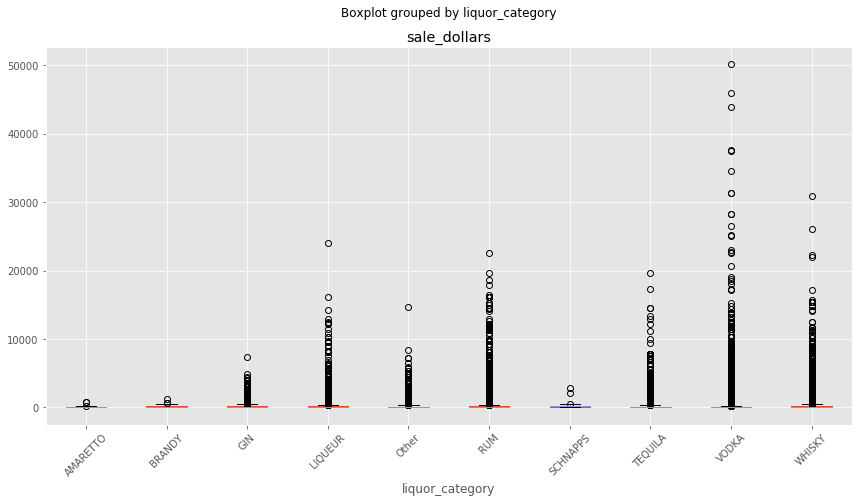

In [39]:
# display boxplot of sale_dollars grouped by liquor_category
plt.style.use('ggplot')
ax = df.boxplot(column = 'sale_dollars', by = 'liquor_category', figsize=(14,7))
plt.xticks(rotation=45)
ax

This box plot is graphing the distribution sale_dollars with the different categories of liquor we have available. Here, we can see there is a significant number of outliers across all categories, so much that you can't really see the boxes on each category. This would suggest we would want to look into a transform.

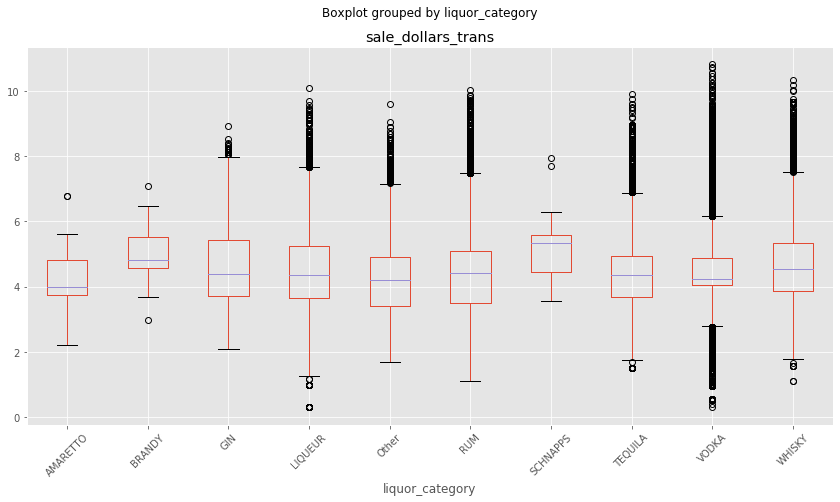

In [40]:
# perform log transformation on sale_dollars due to significant outliers
df['sale_dollars_trans'] = np.log(df['sale_dollars'])

# display boxplot of logged sale dollars grouped by liquor_category
gx = df.boxplot(column = 'sale_dollars_trans', by = 'liquor_category', figsize=(14,7))
plt.xticks(rotation=45)
gx

This is much more helpful for us to see how our distribution of categories compares to one another. Vodka and Whiskey are still showing a wider range of outliers, however Liquer tends to have a wider bounding than the other categories, which suggests that it has a wide variety of pricing. On average, tequila looks to have the higher medium sale value, which suggest that more money is being spent on tequilla on average. 

Using Sales dollars trans will help address outliers in the future.

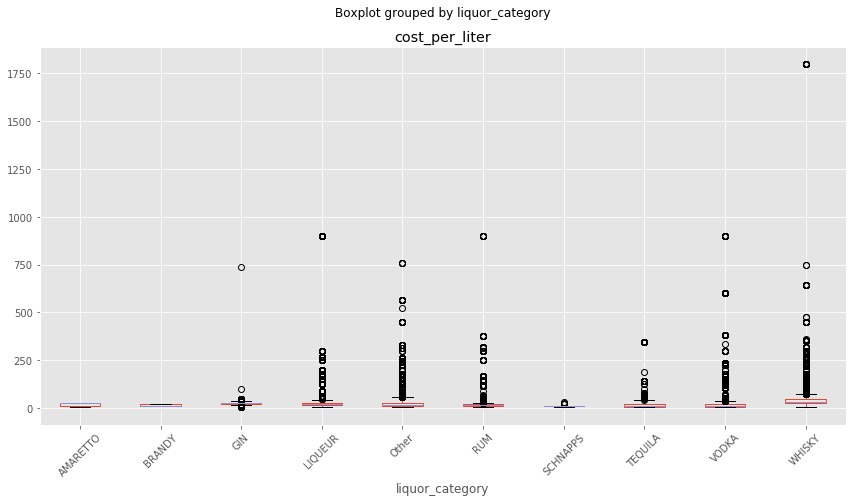

In [41]:
# create new feature of cost_per_liter
df['cost_per_liter'] = df['sale_dollars']/df['volume_sold_liters']

# display boxplot of cost_per_liter grouped by liquor_category
bx = df.boxplot(column = 'cost_per_liter', by = 'liquor_category', figsize=(14,7))
plt.xticks(rotation=45)
bx

Looking at the cost per liter aggregate column. As we discussed previously, cost per liter is calculated via a calculation of total sales_dollars divided by the total volume_sold_ml. The idea of this calculation is to see the varying price of the liquors if we normalize by the volume and sale of the liquors in our set. 

Here, we can see that our distribution is right skewed with a large outlier for whiskey which is going for over 1750 per liter. Looking further into this datapoint, we can see that this datapoint represents Johnnie Walker Blue. 

That said, with the distribution of alcohol types, outside of Johnnie walker blue, we cans see that our cost per liter is going to have a greater than tenfold range, so, i would suggest we create a transform there as well. 

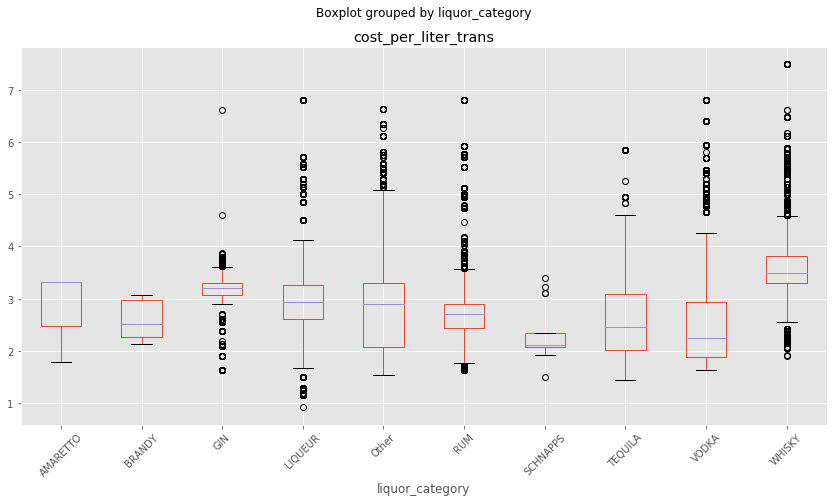

In [42]:
df['cost_per_liter_trans'] = np.log(df['cost_per_liter'])

zx = df.boxplot(column = 'cost_per_liter_trans', by = 'liquor_category', figsize=(14,7))
plt.xticks(rotation=45)
zx

This new box plot shows some interesting insight into the distribution and the value placed on alcohol in our dataset. 

Gin and Tequilla - even with outliers, it is going to have a faily consistent price per liter. 
Liquer - Similar case as GIn, however, it's outliers go a little farther out. 
Other- as expected, has a very wide range with very few outliers. Since this represents all types of alcohol not covered in the other categories, the box plot shape is expected. 

Whiskey - Has a faily consistent bounding, however the number out outliers on either side is very large and larger than the other categories. 

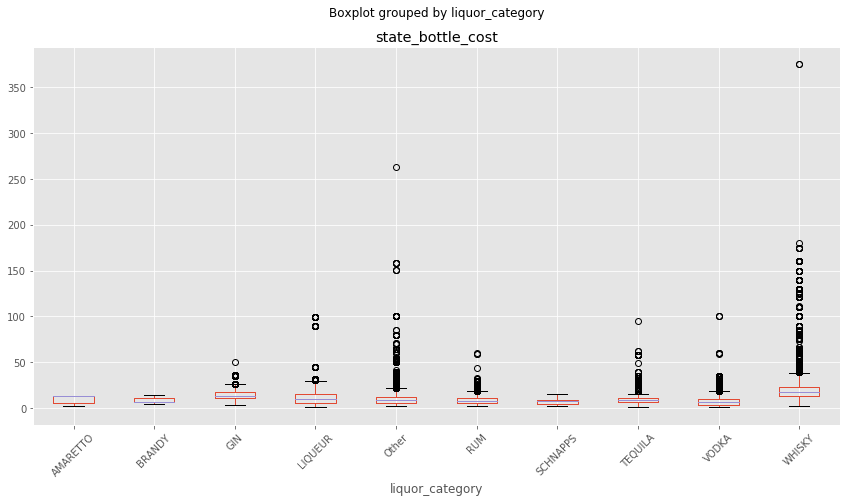

In [43]:
#['pack', 'bottle_volume_ml', 'state_bottle_cost', 'bottles_sold', 'sale_dollars_trans', 'volume_sold_liters']

# display boxplot of sale_dollars grouped by liquor_category
plt.style.use('ggplot')
bx = df.boxplot(column = 'state_bottle_cost', by = 'liquor_category', figsize=(14,7))
plt.xticks(rotation=45)
bx



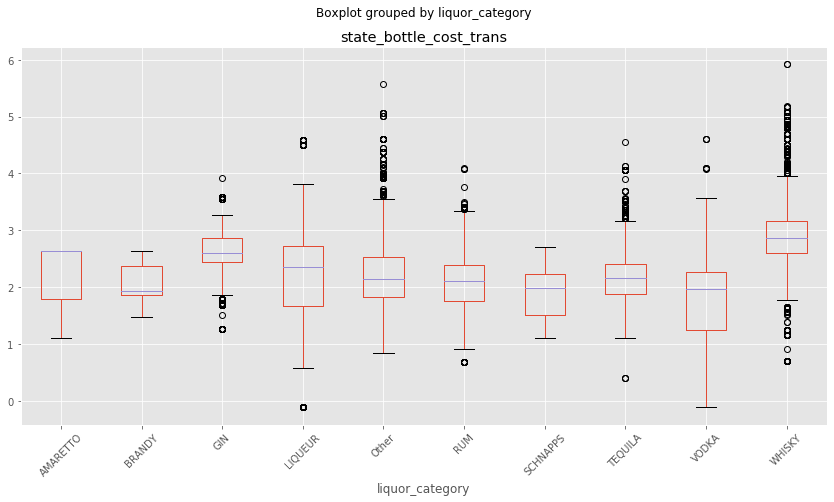

In [44]:
df['state_bottle_cost_trans'] = np.log(df['state_bottle_cost'])

plt.style.use('ggplot')
cx = df.boxplot(column = 'state_bottle_cost_trans', by = 'liquor_category', figsize=(14,7))
plt.xticks(rotation=45)
cx

Looking at state bottle cost, we saw some serious skewing that occured due to outliers, so we decided to transofrm the state bottle cost by the log of the value to help normalize the distribution. Doing so helped to make our box plots cleaner and easier to analyze. 

Looking at the state bottle cost distribution, we can see there is a similar case with skewing that we would need to transform by the log and create a new category called state_bottle_cost_trans.

Next we will do the same thing with the bottles_sold category, which appears to have outliers as well.

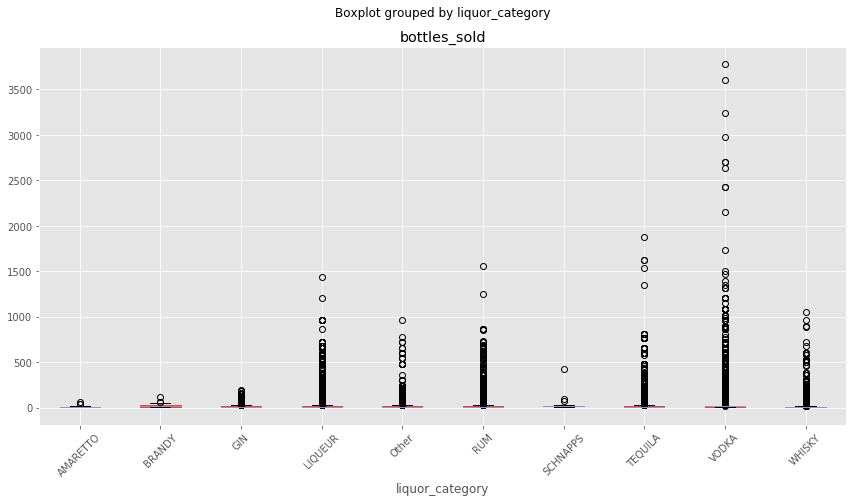

In [45]:
# display boxplot of sale_dollars grouped by liquor_category
plt.style.use('ggplot')
dx = df.boxplot(column = 'bottles_sold', by = 'liquor_category', figsize=(14,7))
plt.xticks(rotation=45)
dx

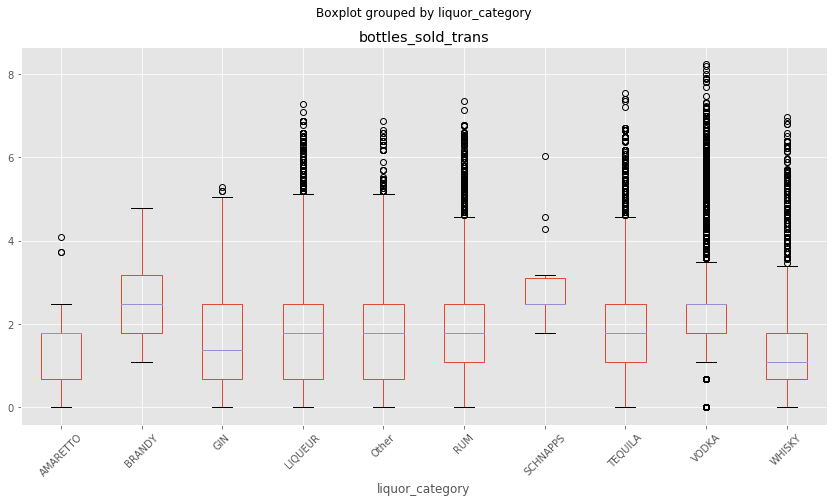

In [46]:
df['bottles_sold_trans'] = np.log(df['bottles_sold'])

plt.style.use('ggplot')
cx = df.boxplot(column = 'bottles_sold_trans', by = 'liquor_category', figsize=(14,7))
plt.xticks(rotation=45)
cx

Next we are going to look at Volume Sold Liters and how that is distributed among our categories. looking at the relationships, we can see there are some outliers that need to be addressed which we will do via a log function. 

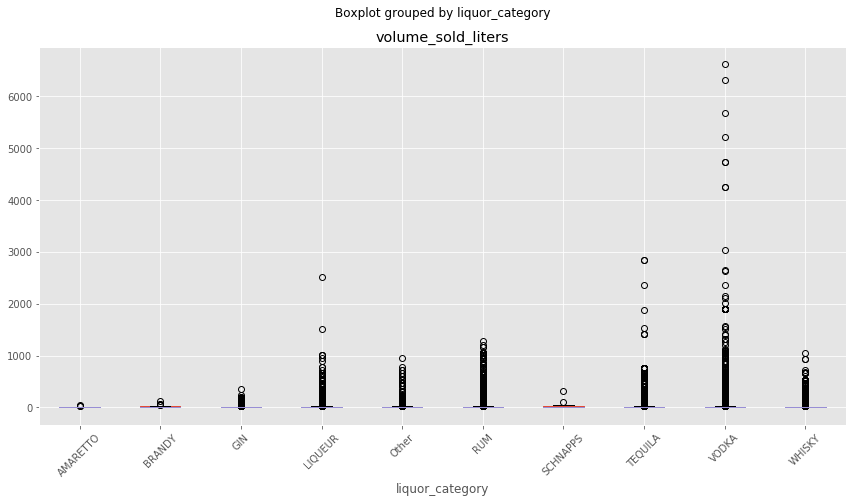

In [47]:
# display boxplot of voume sold grouped by liquor_category
plt.style.use('ggplot')
ex = df.boxplot(column = 'volume_sold_liters', by = 'liquor_category', figsize=(14,7))
plt.xticks(rotation=45)
ex

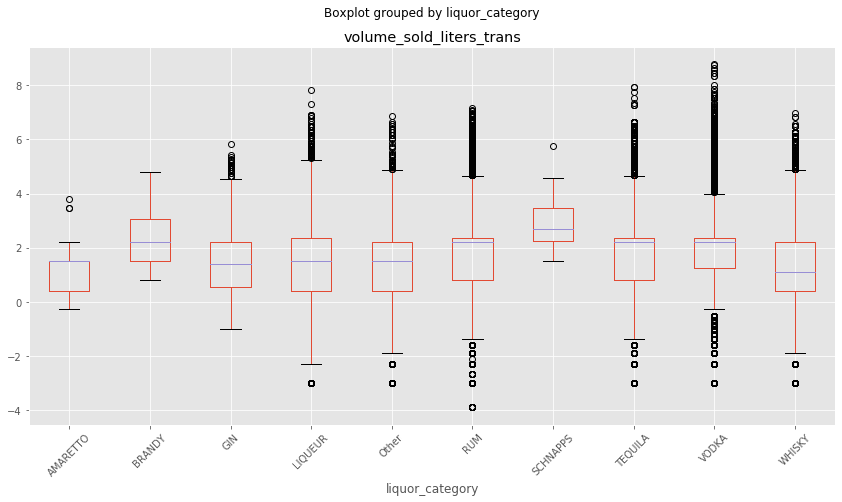

In [48]:
df['volume_sold_liters_trans'] = np.log(df['volume_sold_liters'])

plt.style.use('ggplot')
fx = df.boxplot(column = 'volume_sold_liters_trans', by = 'liquor_category', figsize=(14,7))
plt.xticks(rotation=45)
fx

Now this will be much easier for us to work with. 

## Simple Statistics

The df.describe funciton below provides some simple statistcs for the numeric values in the table. 

Reviewing the 'pack' & 'bottle_volume_ml' variable statistics, we can see that the average transactional sale was about a 12 pack with 960 ml per bottle.  Furthermore, reviewing the 'state_bottle_cost' and 'state_bottle_retail' variables the average cost per bottle is about 10.22 while the average retail price is 15.35. With that said, this goes to align with what a typical box of liquor bottles tend to look like (at 12 per pack) in which a $5 profit is anticipated per bottle.

Another point to consider is the median values are smaller than the mean values. This suggests that our distribution of our sample population is right skewed. 

Lastly, there are a number of outliers within the dataset in which we may need to perform a log tranformation to address.  For example, the 'sale_dollars' variable has max sale amount of 50,186 but the 75th quartile is only at 152.  Also, within the 'volume_sold_liters" variable the max amount is 6,615 liters but the 75th quartile is only 10.5 liters.  Further updats will need to be done to identify and address the outliers within our model.


In [49]:
df.describe()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.0,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,11.950140,960.109795,10.227868,15.345598,12.990820,155.731625,11.411139,3.009274,1.0,4.342939,29.257723,2.766402,2.090235,1.847176,1.576537
std,8.382596,557.811485,8.127904,12.204197,37.810209,523.597441,46.203081,12.205782,0.0,1.061412,80.983248,0.828823,0.707591,1.078662,1.352197
min,1.000000,25.000000,0.890000,1.340000,1.000000,1.340000,0.020000,0.000000,1.0,0.292670,2.500000,0.916291,-0.116534,0.000000,-3.912023
25%,6.000000,750.000000,5.420000,8.130000,3.000000,41.580000,2.250000,0.590000,1.0,3.727619,8.091429,2.090805,1.690096,1.098612,0.810930
50%,12.000000,750.000000,8.260000,12.390000,6.000000,75.120000,9.000000,2.370000,1.0,4.319087,15.428571,2.736221,2.111425,1.791759,2.197225
75%,12.000000,1750.000000,12.670000,19.010000,12.000000,152.940000,10.500000,2.770000,1.0,5.030046,22.146667,3.097687,2.539237,2.484907,2.351375
max,48.000000,6000.000000,374.990000,562.490000,3780.000000,50186.400000,6615.000000,1747.490000,1.0,10.823499,1800.000000,7.495542,5.926899,8.237479,8.797095


To further view and analyze the outliers, the scatter plot below easily shows the sales dollars against volume sold by liters (normalized for outliers).  Also, the table that follows shows the top 10 items listed within sale_dollars and volume_sold liters.

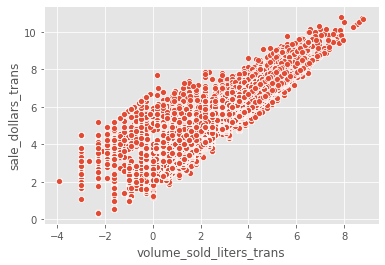

In [50]:
# display scatterplot of x=volume_sold_liters, y= sale_dollars
plt.style.use('ggplot')
sns.scatterplot(x=df.volume_sold_liters_trans, y=df.sale_dollars_trans)

In [51]:
# top 10 table for sale_dollars
df.nlargest(10, 'sale_dollars')['item_description'].reset_index()

,index,item_description
0,380858,TITOS HANDMADE VODKA
1,83996,MEMBERS MARK VODKA
2,150357,KIRKLAND SIGNATURE AMERICAN VODKA
3,149456,KIRKLAND SIGNATURE AMERICAN VODKA
4,42212,KIRKLAND SIGNATURE FRENCH VODKA
5,67216,KIRKLAND SIGNATURE AMERICAN VODKA
6,24758,KIRKLAND SIGNATURE AMERICAN VODKA
7,66805,KIRKLAND SIGNATURE AMERICAN VODKA
8,63553,JAMESON
9,108311,KIRKLAND SIGNATURE AMERICAN VODKA


In [52]:
# top 10 table for volume_sold_liters
df.nlargest(10, 'volume_sold_liters')['item_description'].reset_index()

,index,item_description
0,150357,KIRKLAND SIGNATURE AMERICAN VODKA
1,83996,MEMBERS MARK VODKA
2,149456,KIRKLAND SIGNATURE AMERICAN VODKA
3,67216,KIRKLAND SIGNATURE AMERICAN VODKA
4,24758,KIRKLAND SIGNATURE AMERICAN VODKA
5,66805,KIRKLAND SIGNATURE AMERICAN VODKA
6,108311,KIRKLAND SIGNATURE AMERICAN VODKA
7,150369,KIRKLAND SIGNATURE AMERICAN VODKA
8,42212,KIRKLAND SIGNATURE FRENCH VODKA
9,176490,KIRKLAND PREMIUM GOLDEN MARGARITA


Some additional interesting facts can be found in the mode section. Vodka has the largest number of sales, and the small package stores combined take up more sales than a single big-box retailer. 

The most common pack size is 12 pack, which is efficient for shipping and the most common bottle size is 750 ml. 

December 2019 is the most popular month for alcohol sales, which suggest that people drink heavily that time of year. :)

In [53]:
dfenc.mode()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,liquor_category,store_parent,month,year,monthyear
0,12,750,8.74,13.11,12.0,64.8,9.0,2.37,1.0,VODKA,Other,Dec,2019,Dec-2019


## Visualize Attributes
The following section shows our cross tabulations of the relationships we found with our 2019 liquor data. The bar charts and box plots are able to show the distribution of our data and a comparative between categorical variables in our set. 



In [0]:
df['cost_per_liter'] = df['sale_dollars']/df['volume_sold_liters']
df['grossmargin'] = 1 - df['state_bottle_cost']/df['state_bottle_retail']
df_grouped = df.groupby(by=['liquor_category'])

In [0]:
sales_rateq = df_grouped.bottles_sold.sum()
sales_rated = df_grouped.sale_dollars.sum()
sales_ratecpl = df_grouped.cost_per_liter.mean()
salesgm = df_grouped.grossmargin.mean()

In [0]:
dfsr = pd.DataFrame(sales_rateq)
dfsdol = pd.DataFrame(sales_rated)
dfscpl = pd.DataFrame(sales_ratecpl)
dfsg = pd.DataFrame(salesgm)

In [57]:
salesbyliquor = pd.merge(dfsr, dfsdol, how = 'left', on='liquor_category')
salesbyliquor = pd.merge(salesbyliquor, dfscpl, how = 'left', on='liquor_category')
salesbyliquor = pd.merge(salesbyliquor, dfsg, how = 'left', on='liquor_category')
salesbyliquor

,bottles_sold,sale_dollars,cost_per_liter,grossmargin
liquor_category,,,,
AMARETTO,623.0,9.215910e+03,20.037576,0.333333
BRANDY,602.0,6.468790e+03,13.943690,0.333571
GIN,80870.0,1.797431e+06,24.415458,0.333394
LIQUEUR,912632.0,7.111173e+06,71.136233,0.333447
Other,166464.0,2.292375e+06,29.137241,0.333631
RUM,1006274.0,1.406127e+07,19.890705,0.333418
SCHNAPPS,798.0,8.143140e+03,11.899233,0.333496
TEQUILA,424646.0,5.242035e+06,21.399567,0.333401
VODKA,2287165.0,2.321526e+07,20.041109,0.333572


In [0]:
salesbyliquor = salesbyliquor.reset_index()

The plots below show various views of the data. The top left shows the grouped average cost per liter by the type of liquor in our dataset. Coming in at over 70 dollars per liter, Liqeuer is the most expensive alcohol in our dataset followed by Whiskey at $45. For Whiskey, some of that can come from the Johnnie Walker Blue we discussed previously, the common theme is that whiskey tends to be more expensive liter for liter than the other types of alcohol.

Looking at an aggregate of our different alcohol categories in the top right chart below, we can see that Vodka generated the highest number of sales in our dataset at close to 2.5 million followed by Rum at closer to 1.5 million. This chart seems to show that Vodka and Rum are the two highest-selling alcohols in the state of Iowa in 2019 with Whiskey coming in 3rd. 

In the bottom right chart the quantity sold by category is shown. While liqeuer had the highest average cost per liter, the vodka tended to have the highest sale quantity per purchase among all the alcohol types. This can be attributed to the volume in which vodka can be made and shipped, which likely affected the volume of sale.

On the bottom left, we can see that the gross margin is consistent among all the categories, which suggest that this could be related to a tax associated with the alcohol sales. We do not think profit is included in this database.

Looking at the average bottles sold per pack by way of the liquor categories in our dataset, tequila had the highest amount with over 20 bottles sold per purchase on average. This can be followed by vodka which was referenced earlier.

[Text(0, 0, 'VODKA'),
 Text(0, 0, 'RUM'),
 Text(0, 0, 'LIQUEUR'),
 Text(0, 0, 'TEQUILA'),
 Text(0, 0, 'WHISKY'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'GIN'),
 Text(0, 0, 'SCHNAPPS'),
 Text(0, 0, 'AMARETTO'),
 Text(0, 0, 'BRANDY')]

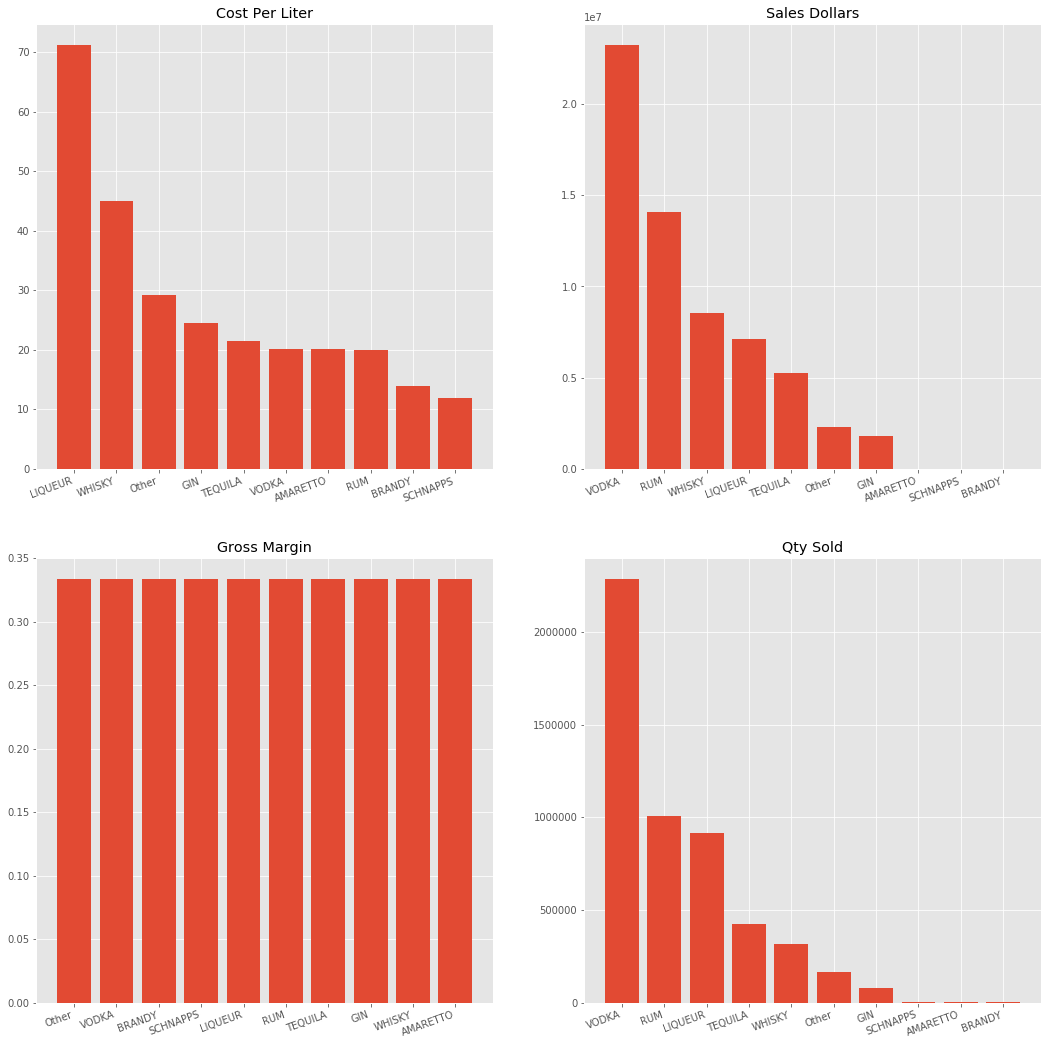

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(18, 18))
sales_rate = salesbyliquor.sort_values(by='sale_dollars', ascending = False)
names = salesbyliquor.sort_values(by='cost_per_liter', ascending=False)['liquor_category'].head(10)
values = salesbyliquor.sort_values(by='cost_per_liter', ascending=False)['cost_per_liter'].head(10)
names2 = salesbyliquor.sort_values(by='sale_dollars', ascending=False)['liquor_category'].head(10)
values2 = salesbyliquor.sort_values(by='sale_dollars', ascending=False)['sale_dollars'].head(10)
names3 = salesbyliquor.sort_values(by='grossmargin',  ascending=False)['liquor_category'].head(10)
values3 = salesbyliquor.sort_values(by='grossmargin',  ascending=False)['grossmargin'].head(10)
names4 = salesbyliquor.sort_values(by='bottles_sold',  ascending=False)['liquor_category'].head(10)
values4 =salesbyliquor.sort_values(by='bottles_sold',  ascending=False)['bottles_sold'].head(10)
axs[0, 0].bar(names, values)
axs[0, 0].set_title('Cost Per Liter')
axs[0, 0].set_xticklabels(names, rotation=20, horizontalalignment='right')
axs[0, 1].bar(names2, values2)
axs[0, 1].set_title('Sales Dollars')
axs[0, 1].set_xticklabels(names2, rotation=20, horizontalalignment='right')
axs[1, 0].bar(names3, values3)
axs[1, 0].set_title('Gross Margin')
axs[1, 0].set_xticklabels(names3, rotation=20, horizontalalignment='right')
axs[1, 1].bar(names4, values4)
axs[1, 1].set_title('Qty Sold')
axs[1, 1].set_xticklabels(names4, rotation=20, horizontalalignment='right')

For our stores in our dataset, as we discussed previously, we decided to focus on the big box retailers as our starting point, and lumped in the smaller stores into a category called "other". As we can see, the other column drove the greatest overall sales at over 2.5 million, however Hy-Vee in Iowa was a close second at 2.3 million in sales. In the state of Iowa, Hy-Vee is a widely popular grocery store chain sells groceries and alocholic beverages.

This same theme is apparent in the QTY sold between retailers in the bottom right. However, interestingly Kum & Go is the retailer with the highest cost per liter. When reviewing the gross margins between the store, our dataset is consistent, which reinforces our hypothesis that this figure represents tax.

In [0]:
df['cost_per_liter'] = df['sale_dollars']/df['volume_sold_liters']
df['grossmargin'] = 1 - df['state_bottle_cost']/df['state_bottle_retail']
df_grouped = df.groupby(by=['store_parent'])

In [0]:
sales_rateq = df_grouped.bottles_sold.sum()
sales_rated = df_grouped.sale_dollars.sum()
sales_ratecpl = df_grouped.cost_per_liter.mean()
salesgm = df_grouped.grossmargin.mean()

In [0]:
dfsr = pd.DataFrame(sales_rateq)
dfsdol = pd.DataFrame(sales_rated)
dfscpl = pd.DataFrame(sales_ratecpl)
dfsg = pd.DataFrame(salesgm)

In [63]:
salesbyparent = pd.merge(dfsr, dfsdol, how = 'left', on='store_parent')
salesbyparent = pd.merge(salesbyparent, dfscpl, how = 'left', on='store_parent')
salesbyparent = pd.merge(salesbyparent, dfsg, how = 'left', on='store_parent')
salesbyparent

,bottles_sold,sale_dollars,cost_per_liter,grossmargin
store_parent,,,,
CVS,11667.0,1.654125e+05,14.996491,0.333440
Caseys,249155.0,2.030145e+06,41.548410,0.333509
Hy-Vee,1730159.0,2.319066e+07,27.382392,0.333465
Kum&Go,107664.0,1.143299e+06,48.554256,0.333437
Other,2315212.0,2.551252e+07,29.769745,0.333494
QuikTrip,68842.0,3.473858e+05,42.388120,0.333608
SamsClub,254317.0,3.769853e+06,21.735604,0.333481
SmokingJoes,69283.0,3.324747e+05,35.413363,0.333543
Target,37346.0,6.690228e+05,20.142758,0.333766


In [0]:
salesbyparent = salesbyparent.reset_index()

[Text(0, 0, 'Other'),
 Text(0, 0, 'Hy-Vee'),
 Text(0, 0, 'Wal-Mart'),
 Text(0, 0, 'SamsClub'),
 Text(0, 0, 'Caseys'),
 Text(0, 0, 'Kum&Go'),
 Text(0, 0, 'SmokingJoes'),
 Text(0, 0, 'QuikTrip'),
 Text(0, 0, 'Walgreens'),
 Text(0, 0, 'Target')]

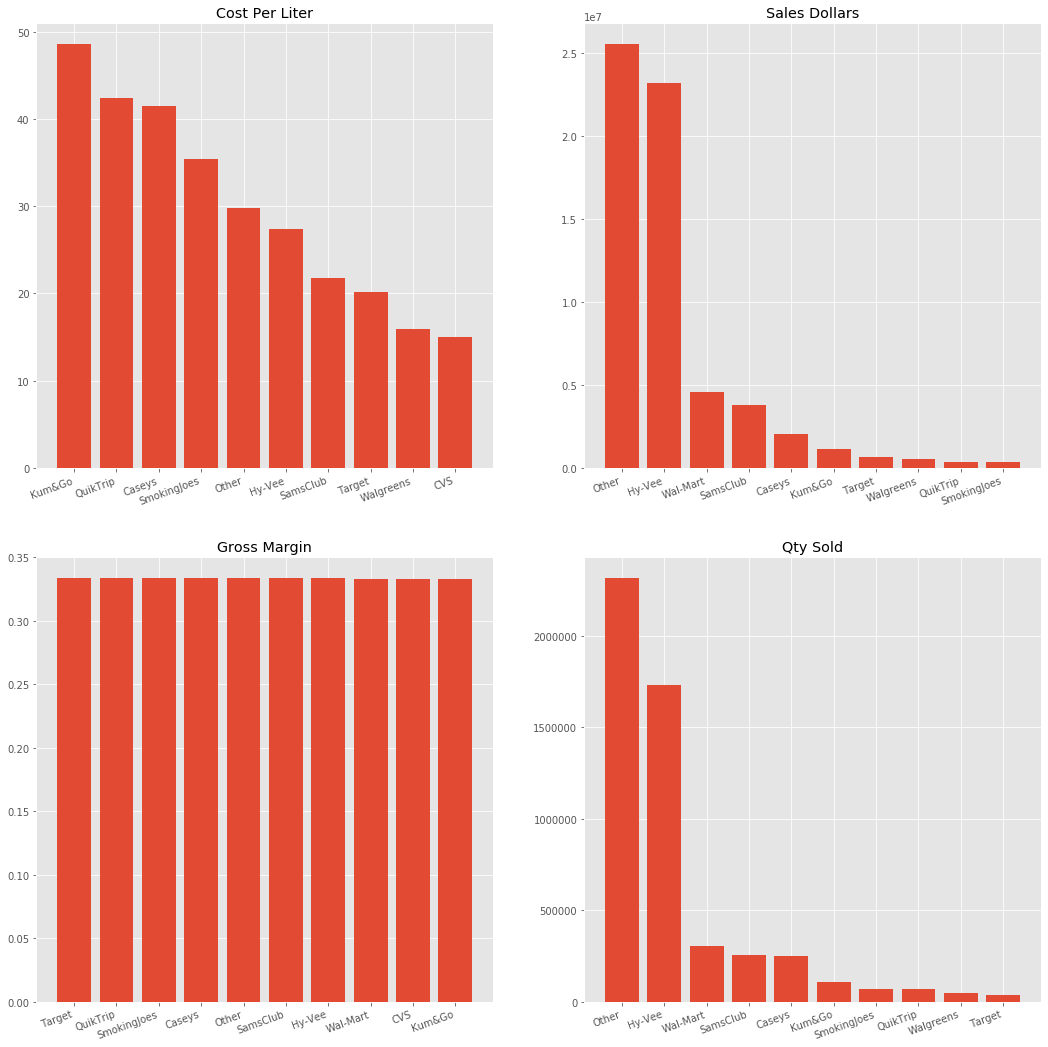

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(18, 18))
sales_rate = salesbyparent.sort_values(by='sale_dollars', ascending = False)
names = salesbyparent.sort_values(by='cost_per_liter', ascending=False)['store_parent'].head(10)
values = salesbyparent.sort_values(by='cost_per_liter', ascending=False)['cost_per_liter'].head(10)
names2 = salesbyparent.sort_values(by='sale_dollars', ascending=False)['store_parent'].head(10)
values2 = salesbyparent.sort_values(by='sale_dollars', ascending=False)['sale_dollars'].head(10)
names3 = salesbyparent.sort_values(by='grossmargin',  ascending=False)['store_parent'].head(10)
values3 = salesbyparent.sort_values(by='grossmargin',  ascending=False)['grossmargin'].head(10)
names4 = salesbyparent.sort_values(by='bottles_sold',  ascending=False)['store_parent'].head(10)
values4 =salesbyparent.sort_values(by='bottles_sold',  ascending=False)['bottles_sold'].head(10)
axs[0, 0].bar(names, values)
axs[0, 0].set_title('Cost Per Liter')
axs[0, 0].set_xticklabels(names, rotation=20, horizontalalignment='right')
axs[0, 1].bar(names2, values2)
axs[0, 1].set_title('Sales Dollars')
axs[0, 1].set_xticklabels(names2, rotation=20, horizontalalignment='right')
axs[1, 0].bar(names3, values3)
axs[1, 0].set_title('Gross Margin')
axs[1, 0].set_xticklabels(names3, rotation=20, horizontalalignment='right')
axs[1, 1].bar(names4, values4)
axs[1, 1].set_title('Qty Sold')
axs[1, 1].set_xticklabels(names4, rotation=20, horizontalalignment='right')

Looking back at our box plot distribution of transformed sale price, we can see that gin had the narrowest box plot which suggests that the distrobution is slim between sales. Whiskey had the greatest number of outliers, and Vodka appeared to be most right skewed. Suggesting that there were a lot of outliers driving Vodka sales. 

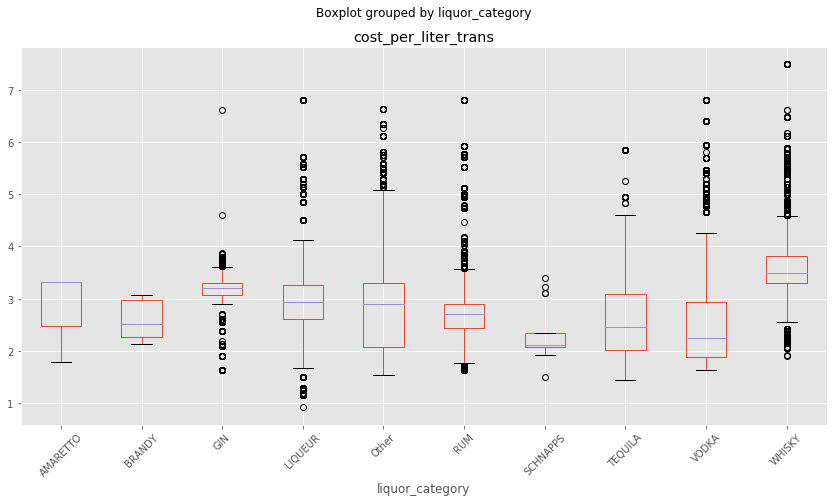

In [66]:
zx = df.boxplot(column = 'cost_per_liter_trans', by = 'liquor_category', figsize=(14,7))
plt.xticks(rotation=45)
zx


### Store Location Analysis
For big box retailers, we focused on Hy-Vee.

In [0]:
hv_df = pd.get_dummies(df['store_parent'], drop_first=False)

hv_df = pd.concat([df, hv_df], axis = 1, sort=False)

In [68]:
hv_df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,liquor_category,store_parent,month,year,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin,CVS,Caseys,Hy-Vee,Kum&Go,Other,QuikTrip,SamsClub,SmokingJoes,Target,Wal-Mart,Walgreens
0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1.0921e+06,IMPORTED DISTILLED SPIRIT SPECIALTY,293,JINRO AMERICA INC,989215,JINRO CHAMISUL GRAPEFRUIT SOJU,20,375,3.85,5.78,20.0,115.60,7.50,1.98,1.0,Other,Other,Nov,2019,Nov-2019,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,0.333910,0,0,0,0,1,0,0,0,0,0,0
1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,1.0913e+06,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,OLE SMOKY APPLE PIE MOONSHINE 70PRF MINI,8,50,8.75,13.13,1.0,13.13,0.05,0.01,1.0,Other,Other,Nov,2019,Nov-2019,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,0.333587,0,0,0,0,1,0,0,0,0,0,0
2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0421e+06,IMPORTED DRY GINS,35,BACARDI USA INC,28233,BOMBAY SAPPHIRE GIN,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,1.0,GIN,Hy-Vee,May,2019,May-2019,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,0.333333,0,0,1,0,0,0,0,0,0,0,0
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24.0,762.24,18.00,4.75,1.0,WHISKY,Hy-Vee,Nov,2019,Nov-2019,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438,0,0,1,0,0,0,0,0,0,0,0
4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1.9012e+06,SPECIAL ORDER ITEMS,285,Charles Jacquin Et Cie,902291,SOOH BARTENDERS BANANAS OVER YOU,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,1.0,Other,Hy-Vee,Nov,2019,Nov-2019,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,0.333572,0,0,1,0,0,0,0,0,0,0,0


In [69]:
hv_grouped = hv_df.groupby(by=['liquor_category', 'Hy-Vee']).median()
hv_grouped

pack  bottle_volume_ml  ...  Wal-Mart  Walgreens
liquor_category Hy-Vee                          ...                     
AMARETTO        0          6               750  ...         0          0
                1          6               750  ...         0          0
BRANDY          0          6               750  ...         0          0
                1         12               750  ...         0          0
GIN             0         12               750  ...         0          0
                1         12               750  ...         0          0
LIQUEUR         0         12               750  ...         0          0
                1         12               750  ...         0          0
Other           0          8               750  ...         0          0
                1          6               750  ...         0          0
RUM             0         12               750  ...         0          0
                1         12               750  ...         0          0
SCHNAPPS        0          9              1000  ...         0          0
                1         12               750  ...         0          0
TEQUILA         0         12              1000  ...         0          0
                1          6              1750  ...         0          0
VODKA           0         12               750  ...         0          0
                1         12               750  ...         0          0
WHISKY          0         12               750  ...         0          0
                1         12               750  ...         0          0

[20 rows x 26 columns]

Look at Hy-Vee in comparison to not Hy-Vee (all other stores)

Roughly 280K transactions were attributed to stores other than Hy-Vee while roughly 120k transactions were attributed to Hy-Vee.

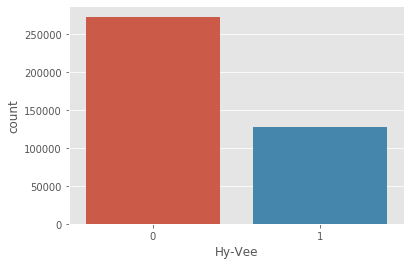

In [70]:
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
sns.countplot(x='Hy-Vee', data=hv_df);

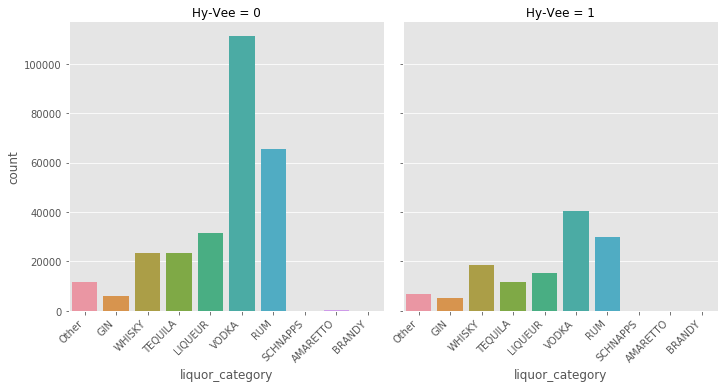

In [71]:
chart=sns.catplot(x='liquor_category', col='Hy-Vee', kind='count', data=hv_df)
chart.set_xticklabels(rotation=45, ha='right')

In the two plots below, we can see the categorical sales tended to remain relatively consistent between Hy-Vee stores as opposed to other liquor stores in the area. This would suggest that Hy-Vee isn't buying liquor differently than anyone else in the state. 

In [72]:
pd.crosstab(hv_df.liquor_category, hv_df['Hy-Vee'], margins=True).style.background_gradient(cmap='autumn_r')

Hy-Vee,0,1,All
liquor_category,,,
AMARETTO,80,19,99
BRANDY,22,6,28
GIN,5887,4926,10813
LIQUEUR,31587,15338,46925
Other,11639,6947,18586
RUM,65346,29691,95037
SCHNAPPS,12,6,18
TEQUILA,23422,11680,35102
VODKA,111250,40387,151637


We were curious to see if HyVee Charged Higher Prices than the competitors. Looking at the cost per liter (which would normalize liquor cost), it appears that Hy-Vee had much higher prices.  

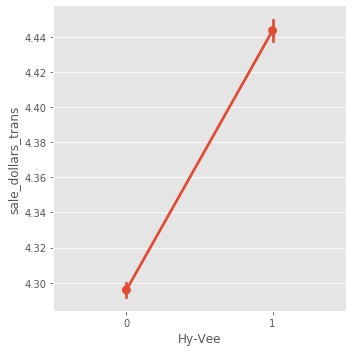

In [73]:
sns.catplot('Hy-Vee', "sale_dollars_trans", kind='point', data=hv_df)

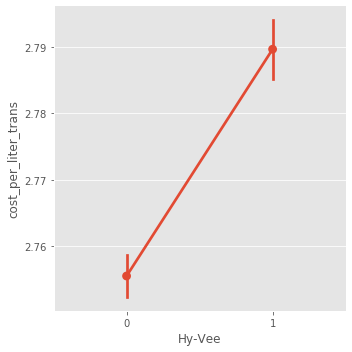

In [74]:
sns.catplot('Hy-Vee', "cost_per_liter_trans", kind='point', data=hv_df)

However, grouping by category, we can see that this might have been due to the volume of whiskey sales Hy-Vee had compared to non-hy-vee stores. The costs are pretty consistent.

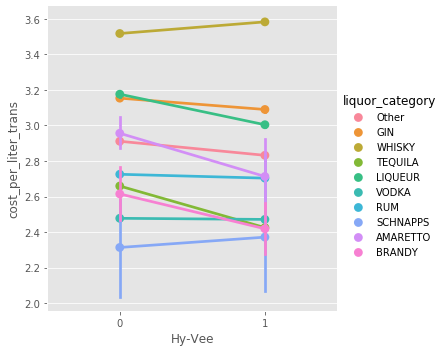

In [75]:
sns.catplot('Hy-Vee','cost_per_liter_trans',hue='liquor_category', kind='point', data=hv_df);

Now comparing against Small Liquor stores vs large big-box stores, using the same code as above but with Other instead of Hy-Vee.

With 0 being Big Box Stores and 1 Being Small Retailers, we can see that consistently, Small Chains are charging higher prices.

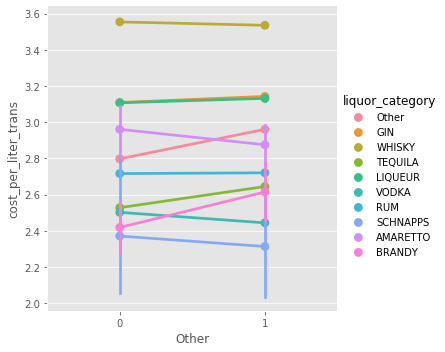

In [76]:
sns.catplot('Other','cost_per_liter_trans',hue='liquor_category', kind='point', data=hv_df);

## Explore Joint Attributes
Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.  

The next section dives deeper into the relationsihps between all the variables in our dataset as well as some of the key relationships found between our features. This will be a starting point for us to better understand if we can begin to think about addressing and removing highly correlated features in our set. 

To measure this, we will be able to run grid plots and heat maps with each feature against one another. The plots that are highly coorelated will be closer to 1 while the plots that are highly negatively correlated will be closer to -1. 

Looking at a heat map of our correlation plot, we can see some interesting occurances happening in the bottom right corner with regards to the volume stats as well as the sales stats. We are seeing cases of volume_sold_gallons and liters having a 0.85 correlation to bottles sold. Which makes sense, because the greater the volume of sales would suggest the greater number of bottles in the purchase. 

In addition, these volume stats are highly correlated at 0.85 to sale dollars. While this is expected as it costs more to get more whiskey, it's interesting as there tends to be somewhwat of a minimal affect with regards to volume discounts. 

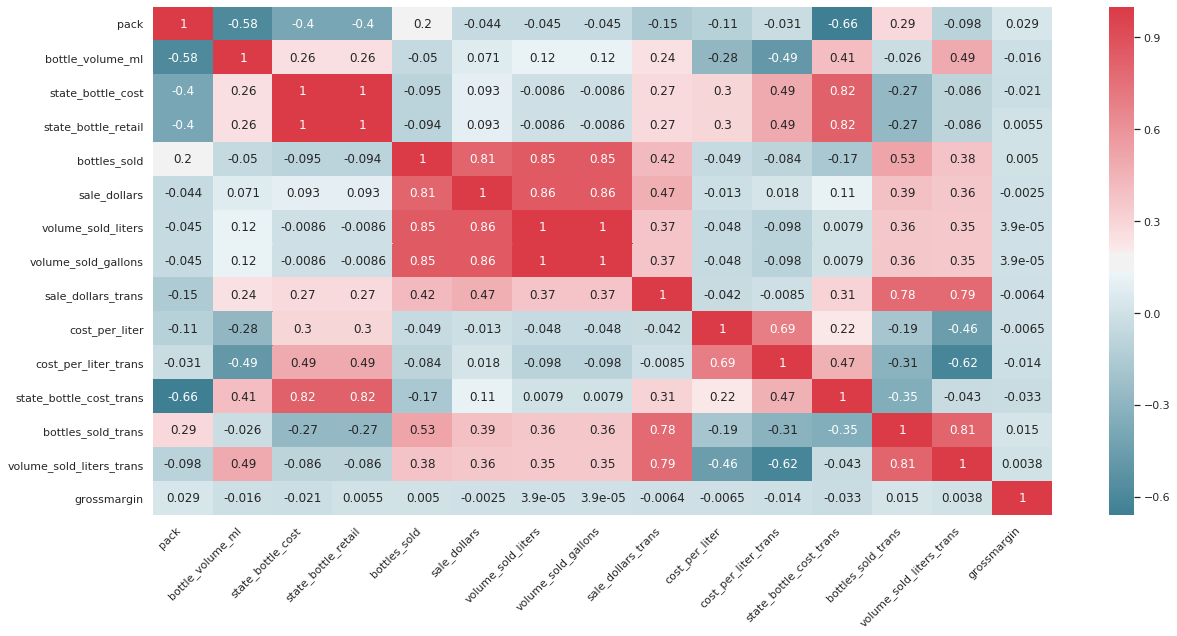

In [77]:
# plot the correlation matrix using seaborn
# https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

# drop the counter attribute as that was used above when dealing with missing values
del df['counter']

# show the heatmap
sns.set(style="darkgrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(18, 9))
chart=sns.heatmap(df.corr(), cmap=cmap, annot=True)
chart.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
f.tight_layout()

To explore our joint attributes, we are going to run a pairplot matrix grouped by liquor category across our key continuous variables.  First, we will look at the raw data, but due to skewness we will need to reference the transformed to get a better sense of the story being told.

Here we can see a couple pair scatter plots that show our coorelations in action. In the bottom right corner, we can see those same highly correlated values visualized in a plot, and broken out by drink type.

Interestingly, we can see some clustering start to appear in some of the relationships, particularly between rum, vodka and whiskey as it relates to volume sold and sales data.

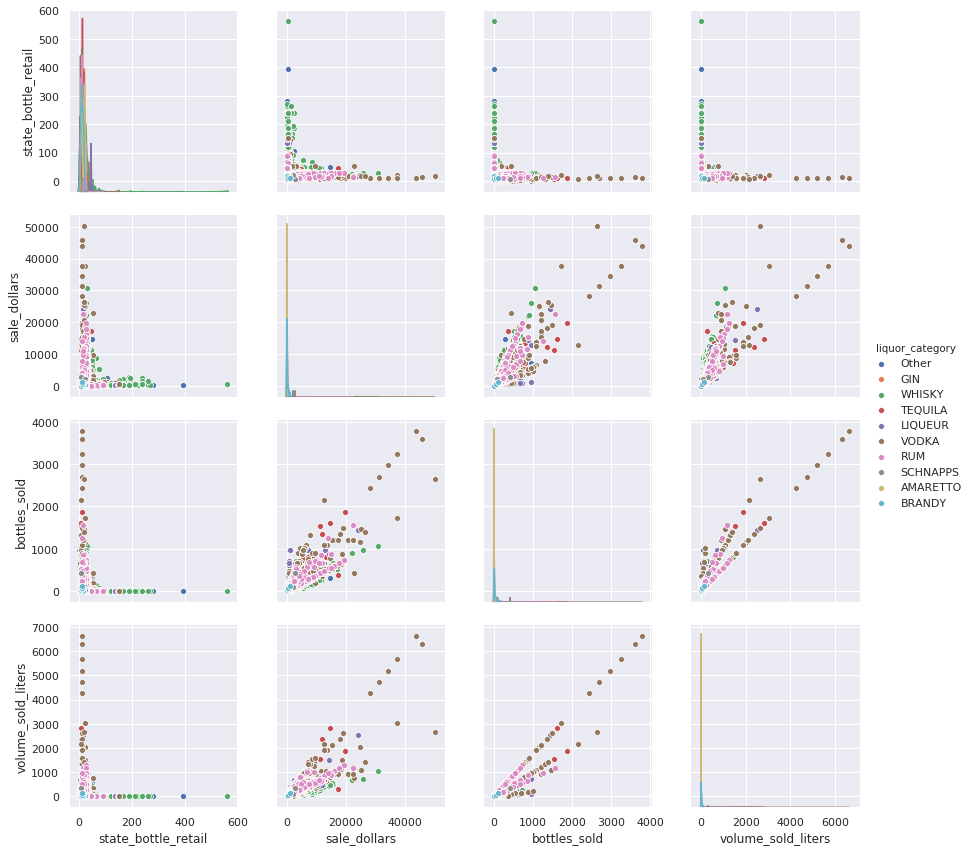

In [78]:
sns.pairplot(dfenc, height=3, hue= 'liquor_category', vars = ['state_bottle_retail', 'sale_dollars', 'bottles_sold', 'volume_sold_liters'])

In our transformed pairplot, we can see some slight clustering emerge between our categories and bottles sold, sales and volume sold

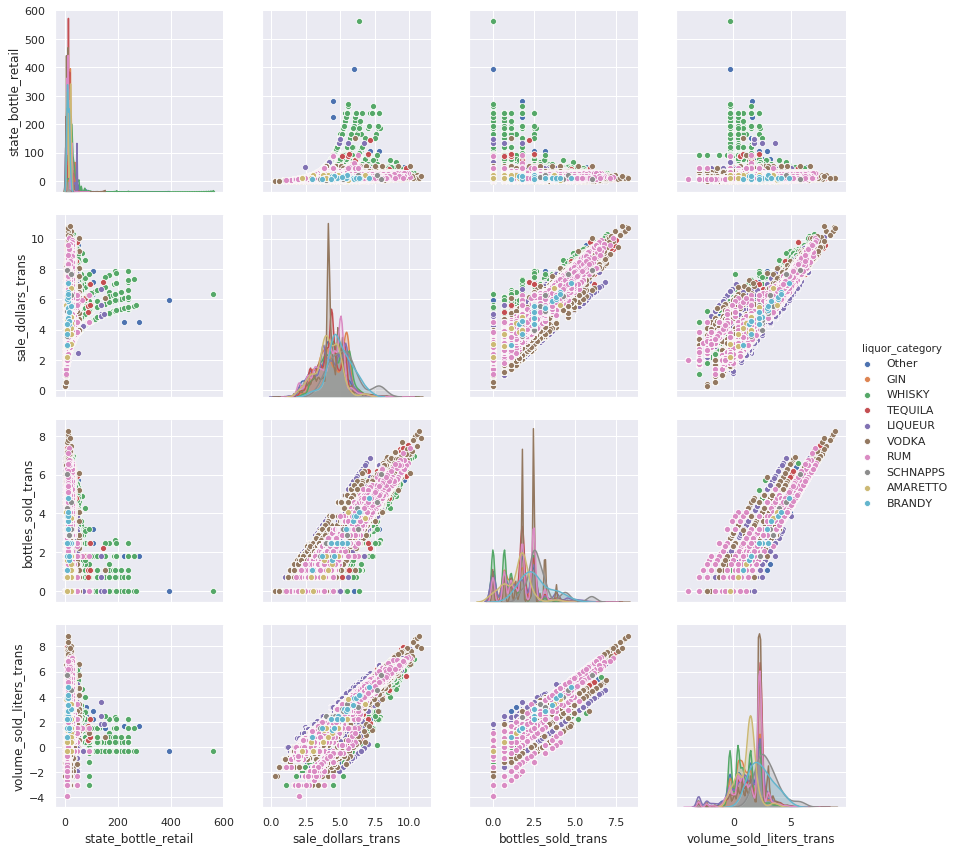

In [79]:
sns.pairplot(df, height=3, hue= 'liquor_category', vars = ['state_bottle_retail', 'sale_dollars_trans', 'bottles_sold_trans', 'volume_sold_liters_trans'])

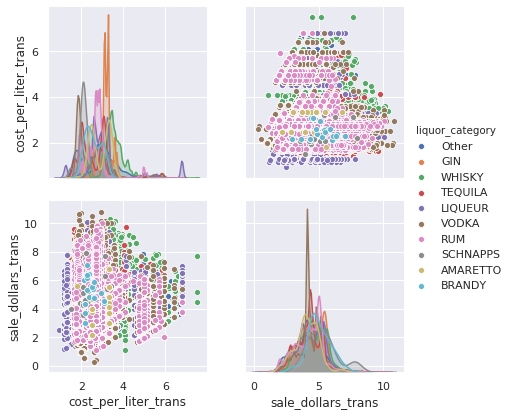

In [80]:
sns.pairplot(df, height=3, hue= 'liquor_category', vars = ['cost_per_liter_trans', 'sale_dollars_trans'])

Next, we are going to look at a cross tab and explore the relationships with alcohol type and store.

As you can see in the table above, Hy Vee and Other take up the majority of sales, however Other is a stronger Vodka seller while Hyvee sales more whieksy. This is confirmed below with our chart that shows the mix of alcohol sales int he story. For each, Vodka and whiskey are among the top sellers. 

In [81]:
#cross tab example
dfcross = pd.crosstab(df['liquor_category'], df['store_parent'],  margins=True, margins_name="Total")
dfcross

store_parent,CVS,Caseys,Hy-Vee,Kum&Go,Other,QuikTrip,SamsClub,SmokingJoes,Target,Wal-Mart,Walgreens,Total
liquor_category,,,,,,,,,,,,
AMARETTO,1,2,19,0,60,0,2,0,15,0,0,99
BRANDY,0,0,6,0,22,0,0,0,0,0,0,28
GIN,45,110,4926,40,4834,23,222,46,146,370,51,10813
LIQUEUR,43,2104,15338,1095,22934,723,776,916,314,2491,191,46925
Other,3,243,6947,192,9503,55,282,149,144,1060,8,18586
RUM,270,5604,29691,4172,42151,1146,1197,1451,823,7619,913,95037
SCHNAPPS,0,0,6,0,12,0,0,0,0,0,0,18
TEQUILA,78,1069,11680,1086,15928,413,549,513,427,3072,287,35102
VODKA,774,9730,40387,9574,69386,3097,1597,3234,1436,10037,2385,151637


In [82]:
#Normalized Cross Tab
dfcrossnorm = pd.crosstab(df['liquor_category'], df['store_parent'], normalize='columns')
dfcrossnorm

store_parent,CVS,Caseys,Hy-Vee,Kum&Go,Other,QuikTrip,SamsClub,SmokingJoes,Target,Wal-Mart,Walgreens
liquor_category,,,,,,,,,,,
AMARETTO,0.000718,0.000103,0.000149,0.000000,0.000327,0.000000,0.000369,0.000000,0.003903,0.000000,0.000000
BRANDY,0.000000,0.000000,0.000047,0.000000,0.000120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GIN,0.032304,0.005677,0.038651,0.002408,0.026313,0.004105,0.041012,0.007015,0.037991,0.014231,0.012624
LIQUEUR,0.030869,0.108577,0.120348,0.065908,0.124836,0.129038,0.143359,0.139698,0.081707,0.095811,0.047277
Other,0.002154,0.012540,0.054509,0.011557,0.051727,0.009816,0.052097,0.022724,0.037471,0.040771,0.001980
RUM,0.193826,0.289194,0.232967,0.251114,0.229439,0.204533,0.221134,0.221290,0.214156,0.293050,0.225990
SCHNAPPS,0.000000,0.000000,0.000047,0.000000,0.000065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TEQUILA,0.055994,0.055166,0.091646,0.065367,0.086700,0.073711,0.101423,0.078237,0.111111,0.118158,0.071040
VODKA,0.555635,0.502116,0.316893,0.576261,0.377687,0.552740,0.295030,0.493213,0.373666,0.386053,0.590347


Below is a heatmap showing the concentration of categorical sales around the stores. Vodka is a strong seller in Others followed by Rum and Liqueur 

[Text(0.5, 0, 'CVS'),
 Text(1.5, 0, 'Caseys'),
 Text(2.5, 0, 'Hy-Vee'),
 Text(3.5, 0, 'Kum&Go'),
 Text(4.5, 0, 'Other'),
 Text(5.5, 0, 'QuikTrip'),
 Text(6.5, 0, 'SamsClub'),
 Text(7.5, 0, 'SmokingJoes'),
 Text(8.5, 0, 'Target'),
 Text(9.5, 0, 'Wal-Mart'),
 Text(10.5, 0, 'Walgreens')]

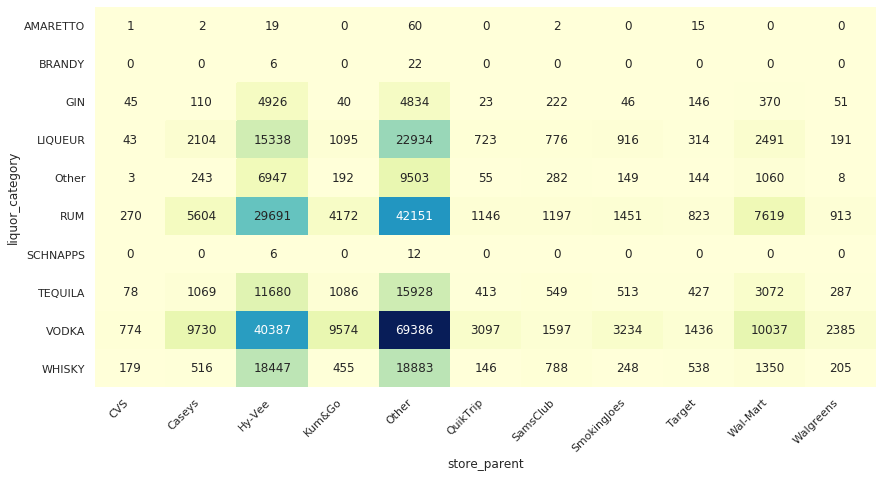

In [83]:

fig, ax = plt.subplots(figsize=(14,7))
chart=sns.heatmap(pd.crosstab([df['liquor_category']], [df['store_parent']]),
            cmap="YlGnBu", annot=True, cbar=False, fmt='g')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

## Explore Attributes and Class

Refining market to whiskey to gather further information about whiskey vendors. Since our analysis is going to focus strictly on whiskey sales, it will be important to see how the whiskey distribution looks within our dataset.

Our goal of exploring attributes and class was to see if there were any relationships between Whiskey purchases and variables within the dataset.  First we analyzed whether or not Whiskey was purchased against 'store_parents' after we analyzed based on location, by county then city.



In [0]:
explore_df= df.copy()

In [85]:
explore_df['WHISKY_Y_N'] = 0
explore_df.loc[explore_df['liquor_category'].str.contains('WHISK'), 'WHISKY_Y_N'] = 1
explore_df.head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin,WHISKY_Y_N
0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1.0921e+06,IMPORTED DISTILLED SPIRIT SPECIALTY,293,JINRO AMERICA INC,989215,JINRO CHAMISUL GRAPEFRUIT SOJU,20,375,3.85,5.78,20.0,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,0.333910,0
1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,1.0913e+06,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,OLE SMOKY APPLE PIE MOONSHINE 70PRF MINI,8,50,8.75,13.13,1.0,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,0.333587,0
2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0421e+06,IMPORTED DRY GINS,35,BACARDI USA INC,28233,BOMBAY SAPPHIRE GIN,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,0.333333,0
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438,1
4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1.9012e+06,SPECIAL ORDER ITEMS,285,Charles Jacquin Et Cie,902291,SOOH BARTENDERS BANANAS OVER YOU,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,0.333572,0


After reviewing the table below, it is interesting to note that when Whiskey is purchased it is in packs less then 10.  Also, the average sale_dollars for a whiskey purchase is much greater than non-whiskey purchases.  This is further pointed in out in the average state_bottle_costs.

Lastly, whiskey purchases tend to have a lower average volume sold then non-whiskey purchases.

In [86]:
explore_df.groupby('WHISKY_Y_N').mean()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
WHISKY_Y_N,,,,,,,,,,,,,,,
0,12.19744,975.639975,9.038022,13.561051,13.622169,150.018468,11.984329,3.160810,4.310794,27.430109,2.675546,1.999206,1.905996,1.635249,0.333496
1,9.82838,826.865645,20.436384,30.656460,7.574039,204.748752,6.493347,1.709145,4.618726,44.938088,3.545919,2.871239,1.342521,1.072807,0.333384


Based on the table below, Target, Sams Club, & Hy-vee have the highest means when it comes to selling Whiskey in their stores.  In other words, of all the liquor transactions processed within these stores there is about 14 percent chance it is associated to a Whiskey purchase.

In [87]:
explore_df.groupby('store_parent').mean()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin,WHISKY_Y_N
store_parent,,,,,,,,,,,,,,,,
CVS,8.888011,1292.264896,11.193266,16.791881,8.375449,118.745506,10.189103,2.686253,4.561370,14.996491,2.540209,2.297302,1.858713,2.021161,0.333440,0.128500
Caseys,13.840541,828.663949,8.157786,12.238608,12.857622,104.765458,8.429397,2.220839,4.395867,41.548410,2.742263,1.837083,2.153447,1.653604,0.333509,0.026628
Hy-Vee,11.260571,977.884399,10.914957,16.374749,13.575518,181.963178,12.725452,3.356514,4.443519,27.382392,2.789660,2.163060,1.874927,1.653859,0.333465,0.144743
Kum&Go,12.548754,784.990069,8.601729,12.904364,6.480318,68.815409,4.870317,1.281165,3.883562,48.554256,2.972045,1.969468,1.508742,0.911518,0.333437,0.027387
Other,12.286360,945.283595,10.195817,15.298920,12.602331,138.871606,10.302226,2.716415,4.215017,29.769745,2.768372,2.072047,1.737434,1.446644,0.333494,0.102785
QuikTrip,21.659647,517.713725,6.195431,9.294808,12.286632,61.999957,4.540974,1.194376,3.564377,42.388120,2.948374,1.509463,1.649054,0.616003,0.333608,0.026057
SamsClub,10.709034,1130.048033,12.294643,18.444247,46.982634,696.444369,57.929146,15.300070,5.615573,21.735604,2.648804,2.257076,2.953145,2.966769,0.333481,0.145575
SmokingJoes,17.075034,631.996340,6.882579,10.325875,10.566265,50.705303,4.097296,1.076428,3.428464,35.413363,2.863924,1.677389,1.345219,0.564539,0.333543,0.037822
Target,8.603435,1197.950820,13.162685,19.770991,9.717929,174.088683,10.175969,2.682162,5.012392,20.142758,2.788696,2.447197,2.159862,2.223696,0.333766,0.139995


As you can see within the table below most whiskey purchases occur in Polk county, with Linn, Johnson, Scott, and Black Hawk following.

In [88]:
large_county_df = explore_df.groupby('county').sum().reset_index()
large_county_df.nlargest(5, 'WHISKY_Y_N')

,county,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin,WHISKY_Y_N
99,POLK,853362,61642605,717556.89,1076486.63,1133279.0,1.346872e+07,914660.94,241251.61,306254.677096,2.298298e+06,195819.037374,142853.749518,135569.422161,110435.639721,22886.529448,8002
74,LINN,426684,31014240,326854.16,490395.06,502202.0,5.450921e+06,420719.63,110967.38,146550.638037,9.330499e+05,91898.053704,67625.681089,65341.757966,54652.584332,11169.127429,3271
66,JOHNSON,260728,19528625,237456.01,356228.32,287400.0,3.887658e+06,273292.84,72077.98,94479.371434,6.835080e+05,62570.122977,46423.395391,39217.252740,31909.248457,7271.252540,3078
108,SCOTT,298560,20928170,232893.03,349386.79,403272.0,4.398128e+06,323274.87,85279.12,103905.744945,7.195472e+05,64666.097359,46861.003554,47627.217608,39239.647586,7742.360775,2531
7,BLACK HAWK,265070,19505898,210197.39,315364.95,281025.0,3.294568e+06,238448.07,62882.56,90061.957685,5.960002e+05,58647.357903,43300.347472,38191.967719,31414.599783,7044.799930,2255


To further breakdown the location of whiskey purchases, we can see that Des Moines leads all other cities with Cedar Rapids coming in second.

In [89]:
large_county_df = explore_df.groupby('city').sum().reset_index()
large_county_df.nlargest(5, 'WHISKY_Y_N')

,city,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin,WHISKY_Y_N
104,Des Moines,423694,27738450,331606.10,497486.45,675306.0,7.491385e+06,509390.47,134394.60,145089.597527,1.056490e+06,91146.045437,65308.880274,66770.874652,53943.552090,10698.989996,3759
59,Cedar Rapids,346493,23996240,258508.39,387849.70,379078.0,4.056567e+06,307559.29,81107.86,113988.134529,7.479715e+05,73177.273671,53171.197821,50083.730751,40810.860858,8824.777610,2711
415,West Des Moines,136061,10934065,132454.17,198702.63,173332.0,2.547537e+06,175258.96,46231.37,53207.026976,4.157143e+05,34525.673802,25722.635537,22679.074641,18681.353174,3951.374495,1735
16,Ames,119792,10763090,126964.23,190461.50,124779.0,1.720985e+06,126624.42,33392.24,48473.839542,3.113226e+05,31197.282266,24517.256257,19492.503939,17276.557276,3671.592145,1663
192,Iowa City,136358,10064050,119422.65,179155.77,155786.0,2.013591e+06,140593.59,37079.60,49782.602350,3.471320e+05,32311.201040,23942.272974,21246.243295,17471.401310,3778.184766,1596


### Whiskey Specific Analysis

The first thing we are going to do is copy the original df into a dfwhiskey dataframe.  After we will be filtering for only the 'WHISKY' liquor category.  Note, the new dfwhiskey datafram should have the same features of the original df except it is only filtered for 'WHISKY' specific transactions. 

In [90]:
# copy original df into dfwhiskey dataframe
dfwhiskey = df.copy()

#filter for only the 'WHISKY' liquor_category
dfwhiskey = dfwhiskey[dfwhiskey['liquor_category']=='WHISKY']

# Here's the head of our dataset so we can see how it looks
dfwhiskey.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24.0,762.24,18.0,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438
5,INV-23540300028,2019-11-27,4312,I-80 LIQUOR / COUNCIL BLUFFS,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,1.0123e+06,SINGLE MALT SCOTCH,370,PERNOD RICARD USA,5037,GLENLIVET 12YR,12,1000,28.98,43.47,6.0,260.82,6.0,1.58,WHISKY,Other,Nov,2019,Nov-2019,5.563831,43.470000,3.772071,3.366606,1.791759,1.791759,0.333333
15,INV-19970300001,2019-06-13,2675,HY-VEE #2 / CORALVILLE,3285 Crosspark Rd,Coralville,52241,POINT (-91.60627100000002 41.721438),52,JOHNSON,1.0116e+06,STRAIGHT RYE WHISKIES,287,CHATHAM IMPORTS INC,27060,MICHTERS US1 KENTUCKY STRAIGHT SINGLE BARREL R...,6,750,21.59,32.39,18.0,583.02,13.5,3.56,WHISKY,Hy-Vee,Jun,2019,Jun-2019,6.368221,43.186667,3.765532,3.072230,2.890372,2.602690,0.333436
18,INV-20399700023,2019-07-03,3990,CORK AND BOTTLE / OSKALOOSA,309 A Ave West,Oskaloosa,52577,POINT (-92.648153 41.296228),62,MAHASKA,1.7011e+06,TEMPORARY & SPECIALTY PACKAGES,260,DIAGEO AMERICAS,100700,CROWN ROYAL DELUXE W/50ML VANILLA & 50ML APPLE,6,850,15.59,23.39,6.0,140.34,5.1,1.34,WHISKY,Other,Jul,2019,Jul-2019,4.944068,27.517647,3.314828,2.746630,1.791759,1.629241,0.333476
20,INV-23104300006,2019-11-08,4209,WAL-MART 5748 / GRIMES,2150 East 1st St,Grimes,50111,POINT (-93.771698 41.688332),77,POLK,1.7011e+06,TEMPORARY & SPECIALTY PACKAGES,255,Infinium Spirits,87026,SKREWBALL PEANUT BUTTER WHISKEY,6,750,18.50,27.75,24.0,666.00,18.0,4.75,WHISKY,Wal-Mart,Nov,2019,Nov-2019,6.501290,37.000000,3.610918,2.917771,3.178054,2.890372,0.333333


Next, we are going to do a series of calculations to add new columns to our dataset which provides some insight to the sales data of our whiskies. 

These include the following new features:
- profit = state_bottle_retail / bottles_sold
- totalcost = state_bottle_cost * bottles_sold
- revenue = state_bottle_retail * bottles_sold
- grossmargin = (revenue - totalcost)/revenue

Ultimately, this is going to give us a clear view of the profatability, and the market size of whiskey so we can better analyze and predict within the dataset.

In [0]:
#do some calculations for cost and profit
dfwhiskey['profit'] = dfwhiskey['state_bottle_retail']*dfwhiskey['bottles_sold'] - dfwhiskey['state_bottle_cost']* dfwhiskey['bottles_sold']

In [0]:
dfwhiskey['totalcost'] = dfwhiskey['state_bottle_cost']* dfwhiskey['bottles_sold']

In [0]:
dfwhiskey['revenue'] = dfwhiskey['state_bottle_retail']*dfwhiskey['bottles_sold']

In [0]:
dfwhiskey['grossmargin'] = (dfwhiskey['revenue'] - dfwhiskey['totalcost']) / dfwhiskey['revenue']

Here, we sorted gross margin of sale within our data set to get a clearer view of how margins tend to look within the sales in our dataset. 

As we can see, there is a 33% margin that appears across almost all of our sales when you calculate the percentage of what is remaining from the cost over the revenue. We are thiking that is a standard state tax cost for whiskies in the state of Iowa.

In [0]:
#lets do the transforms we did earlier in the EDA
dfwhiskey['sale_dollars_trans'] = np.log(dfwhiskey['sale_dollars'])
dfwhiskey['cost_per_liter_trans'] = np.log(dfwhiskey['cost_per_liter'])

In [96]:
dfwhiskey.sort_values(by='grossmargin', ascending=False).head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin,profit,totalcost,revenue
121334,INV-19122500001,2019-05-02,2501,HY-VEE #2 / AMES,640 Lincolnway,Ames,50010,POINT (-93.619455 42.022848),85,STORY,1.0122e+06,SCOTCH WHISKIES,55,SAZERAC NORTH AMERICA,8824,LAUDER'S,24,375,3.21,4.82,6.0,28.92,2.25,0.59,WHISKY,Hy-Vee,May,2019,May-2019,3.364533,12.853333,2.553603,1.166271,1.791759,0.810930,0.334025,9.66,19.26,28.92
78319,INV-20133500037,2019-06-21,3403,ECON-O-MART / COLUMBUS JUNCTION,103 Walnut St. E,Columbus Junction,52738,POINT (-91.359363 41.280107),58,LOUISA,1.0122e+06,SCOTCH WHISKIES,55,SAZERAC NORTH AMERICA,8824,LAUDER'S,24,375,3.21,4.82,3.0,14.46,1.12,0.29,WHISKY,Other,Jun,2019,Jun-2019,2.671386,12.910714,2.558058,1.166271,1.098612,0.113329,0.334025,4.83,9.63,14.46
121223,INV-18688900004,2019-04-10,2501,HY-VEE #2 / AMES,640 Lincolnway,Ames,50010,POINT (-93.619455 42.022848),85,STORY,1.0122e+06,SCOTCH WHISKIES,55,SAZERAC NORTH AMERICA,8824,LAUDER'S,24,375,3.21,4.82,6.0,28.92,2.25,0.59,WHISKY,Hy-Vee,Apr,2019,Apr-2019,3.364533,12.853333,2.553603,1.166271,1.791759,0.810930,0.334025,9.66,19.26,28.92
121625,INV-18344800004,2019-03-26,5443,1ST STOP BEVERAGE SHOP,2839 East University Ave.,Des Moines,50317,POINT (-93.561517 41.600476),77,POLK,1.0122e+06,SCOTCH WHISKIES,55,SAZERAC NORTH AMERICA,8824,LAUDER'S,24,375,3.21,4.82,24.0,115.68,9.00,2.37,WHISKY,Other,Mar,2019,Mar-2019,4.750828,12.853333,2.553603,1.166271,3.178054,2.197225,0.334025,38.64,77.04,115.68
121329,INV-17879500032,2019-03-04,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0122e+06,SCOTCH WHISKIES,55,SAZERAC NORTH AMERICA,8824,LAUDER'S,24,375,3.21,4.82,6.0,28.92,2.25,0.59,WHISKY,Hy-Vee,Mar,2019,Mar-2019,3.364533,12.853333,2.553603,1.166271,1.791759,0.810930,0.334025,9.66,19.26,28.92


Looking at more grossmargin values, we still see the same 33%

In [97]:
dfwhiskey.head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin,profit,totalcost,revenue
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24.0,762.24,18.0,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438,254.16,508.08,762.24
5,INV-23540300028,2019-11-27,4312,I-80 LIQUOR / COUNCIL BLUFFS,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,1.0123e+06,SINGLE MALT SCOTCH,370,PERNOD RICARD USA,5037,GLENLIVET 12YR,12,1000,28.98,43.47,6.0,260.82,6.0,1.58,WHISKY,Other,Nov,2019,Nov-2019,5.563831,43.470000,3.772071,3.366606,1.791759,1.791759,0.333333,86.94,173.88,260.82
15,INV-19970300001,2019-06-13,2675,HY-VEE #2 / CORALVILLE,3285 Crosspark Rd,Coralville,52241,POINT (-91.60627100000002 41.721438),52,JOHNSON,1.0116e+06,STRAIGHT RYE WHISKIES,287,CHATHAM IMPORTS INC,27060,MICHTERS US1 KENTUCKY STRAIGHT SINGLE BARREL R...,6,750,21.59,32.39,18.0,583.02,13.5,3.56,WHISKY,Hy-Vee,Jun,2019,Jun-2019,6.368221,43.186667,3.765532,3.072230,2.890372,2.602690,0.333436,194.40,388.62,583.02
18,INV-20399700023,2019-07-03,3990,CORK AND BOTTLE / OSKALOOSA,309 A Ave West,Oskaloosa,52577,POINT (-92.648153 41.296228),62,MAHASKA,1.7011e+06,TEMPORARY & SPECIALTY PACKAGES,260,DIAGEO AMERICAS,100700,CROWN ROYAL DELUXE W/50ML VANILLA & 50ML APPLE,6,850,15.59,23.39,6.0,140.34,5.1,1.34,WHISKY,Other,Jul,2019,Jul-2019,4.944068,27.517647,3.314828,2.746630,1.791759,1.629241,0.333476,46.80,93.54,140.34
20,INV-23104300006,2019-11-08,4209,WAL-MART 5748 / GRIMES,2150 East 1st St,Grimes,50111,POINT (-93.771698 41.688332),77,POLK,1.7011e+06,TEMPORARY & SPECIALTY PACKAGES,255,Infinium Spirits,87026,SKREWBALL PEANUT BUTTER WHISKEY,6,750,18.50,27.75,24.0,666.00,18.0,4.75,WHISKY,Wal-Mart,Nov,2019,Nov-2019,6.501290,37.000000,3.610918,2.917771,3.178054,2.890372,0.333333,222.00,444.00,666.00


In [98]:
df_grouped = dfwhiskey.groupby(by=['vendor_name'])
df_grouped.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin,profit,totalcost,revenue
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438,254.16,508.08,762.24
5,INV-23540300028,2019-11-27,4312,I-80 LIQUOR / COUNCIL BLUFFS,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,1.0123e+06,SINGLE MALT SCOTCH,370,PERNOD RICARD USA,5037,GLENLIVET 12YR,12,1000,28.98,43.47,6.0,260.82,6.00,1.58,WHISKY,Other,Nov,2019,Nov-2019,5.563831,43.470000,3.772071,3.366606,1.791759,1.791759,0.333333,86.94,173.88,260.82
15,INV-19970300001,2019-06-13,2675,HY-VEE #2 / CORALVILLE,3285 Crosspark Rd,Coralville,52241,POINT (-91.60627100000002 41.721438),52,JOHNSON,1.0116e+06,STRAIGHT RYE WHISKIES,287,CHATHAM IMPORTS INC,27060,MICHTERS US1 KENTUCKY STRAIGHT SINGLE BARREL R...,6,750,21.59,32.39,18.0,583.02,13.50,3.56,WHISKY,Hy-Vee,Jun,2019,Jun-2019,6.368221,43.186667,3.765532,3.072230,2.890372,2.602690,0.333436,194.40,388.62,583.02
18,INV-20399700023,2019-07-03,3990,CORK AND BOTTLE / OSKALOOSA,309 A Ave West,Oskaloosa,52577,POINT (-92.648153 41.296228),62,MAHASKA,1.7011e+06,TEMPORARY & SPECIALTY PACKAGES,260,DIAGEO AMERICAS,100700,CROWN ROYAL DELUXE W/50ML VANILLA & 50ML APPLE,6,850,15.59,23.39,6.0,140.34,5.10,1.34,WHISKY,Other,Jul,2019,Jul-2019,4.944068,27.517647,3.314828,2.746630,1.791759,1.629241,0.333476,46.80,93.54,140.34
20,INV-23104300006,2019-11-08,4209,WAL-MART 5748 / GRIMES,2150 East 1st St,Grimes,50111,POINT (-93.771698 41.688332),77,POLK,1.7011e+06,TEMPORARY & SPECIALTY PACKAGES,255,Infinium Spirits,87026,SKREWBALL PEANUT BUTTER WHISKEY,6,750,18.50,27.75,24.0,666.00,18.00,4.75,WHISKY,Wal-Mart,Nov,2019,Nov-2019,6.501290,37.000000,3.610918,2.917771,3.178054,2.890372,0.333333,222.00,444.00,666.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246015,INV-21252600005,2019-08-15,4129,CYCLONE LIQUORS,626 Lincoln Way,Ames,50010,POINT (-93.618911 42.022854),85,STORY,1.0116e+06,STRAIGHT RYE WHISKIES,608,Wilderness Trail Distillery,926610,WILDERNESS TRAIL SETTLERS SELECT,6,750,30.00,45.00,6.0,270.00,4.50,1.18,WHISKY,Other,Aug,2019,Aug-2019,5.598422,60.000000,4.094345,3.401197,1.791759,1.504077,0.333333,90.00,180.00,270.00
314264,INV-21229200003,2019-08-14,3773,BENZ DISTRIBUTING,501 7th Ave SE,Cedar Rapids,52401,POINT (-91.659875 41.97574),57,LINN,1.0124e+06,IRISH WHISKIES,91,Castle Brands,15560,CLONTARF 1014 CLASSIC BLEND,6,750,9.99,14.99,18.0,269.82,13.50,3.56,WHISKY,Other,Aug,2019,Aug-2019,5.597755,19.986667,2.995065,2.301585,2.890372,2.602690,0.333556,90.00,179.82,269.82
314265,INV-17524000177,2019-02-13,4129,CYCLONE LIQUORS,626 Lincoln Way,Ames,50010,POINT (-93.618911 42.022854),85,STORY,1.0124e+06,IRISH WHISKIES,91,Castle Brands,15560,CLONTARF 1014 CLASSIC BLEND,6,750,9.99,14.99,1.0,14.99,0.75,0.19,WHISKY,Other,Feb,2019,Feb-2019,2.707383,19.986667,2.995065,2.301585,0.000000,-0.287682,0.333556,5.00,9.99,14.99
314266,INV-19589600071,2019-05-24,3868,WAL-MART 3630 / MARION,5491 Business Hwy 151,Marion,52302,blank,57,LINN,1.0124e+06,IRISH WHISKIES,91,Castle Brands,15560,CLONTARF 1014 CLASSIC BLEND,6,750,9.99,14.99,6.0,89.94,4.50,1.18,WHISKY,Wal-Mart,May,201

To look into some aggregate sums within our whiskey dataset, we are going to create new varuables for the sum of bottles sold and sale_dollars, as well as the mean of cost per liter and gross margin. 

Also, we will create datagrames for each so we can see how the whiskey's distribute in these aggregate figures.

In [0]:
sales_rateq = df_grouped.bottles_sold.sum()
sales_rated = df_grouped.sale_dollars.sum()
sales_ratecpl = df_grouped.cost_per_liter.mean()
salesgm = df_grouped.grossmargin.mean()

In [0]:
dfsr = pd.DataFrame(sales_rateq)
dfsdol = pd.DataFrame(sales_rated)
dfscpl = pd.DataFrame(sales_ratecpl)
dfsg = pd.DataFrame(salesgm)

In [101]:
dfsr.sort_values(by='bottles_sold', ascending=False).head(10)

,bottles_sold
vendor_name,
PERNOD RICARD USA,106242.0
DIAGEO AMERICAS,61472.0
Infinium Spirits,29598.0
Jim Beam Brands,17865.0
William Grant & Sons Inc,15968.0
SAZERAC COMPANY INC,12058.0
SAZERAC NORTH AMERICA,10758.0
BACARDI USA INC,7734.0
Brown Forman Corp.,5248.0


Looking at the top 10 bottles sold in the whiskey category, we can see that the number one on the list is Pernod Ricard at over 100k bolttles sold, followed distantly by Dieago Americas at 29,500. 

In [102]:
dfsdol.sort_values(by='sale_dollars', ascending=False).head(10)

,sale_dollars
vendor_name,
PERNOD RICARD USA,2991361.73
DIAGEO AMERICAS,1730980.32
Infinium Spirits,833863.54
William Grant & Sons Inc,510400.47
Jim Beam Brands,351270.31
BACARDI USA INC,217182.37
SAZERAC COMPANY INC,216270.33
Edrington Group USA LLC,186306.81
MOET HENNESSY USA,168206.25


As a function of bottles sold, we are seeing a similar distirbution with regards to sale_dollars in our top whiskies. Pernod Richard is nearing 3 million dollars in sales followed by Diageo Americas that is under 2 million dollars in sales. 

In [103]:
dfscpl.sort_values(by='cost_per_liter', ascending=False).head(10)

,cost_per_liter
vendor_name,
PACIFIC EDGE WINE & SPIRITS,145.564444
IMPEX BEVERAGE INC,123.086667
GoAmericaGo Beverages LLC,104.238717
W J Deutsch & Sons LTD,93.320000
HOTALING & CO,89.184762
MOET HENNESSY USA,74.180870
"Foundry Distilling Company, LLC",71.983333
Vision Wine & Spirit LLC,69.010256
Paterno Imports LTD,68.098667


Interestingly, looking at the high cost per liter vendors, Pactific Edge Wine and Spirits has the highest cost per liter at over 145 dollars, followed by Impex Beverage and Hotaling at just under 125 dollars. 

In [104]:
salesbyvendor = pd.merge(dfsr, dfsdol, how = 'left', on='vendor_name')
salesbyvendor = pd.merge(salesbyvendor, dfscpl, how = 'left', on='vendor_name')
salesbyvendor = pd.merge(salesbyvendor, dfsg, how = 'left', on='vendor_name')
salesbyvendor

,bottles_sold,sale_dollars,cost_per_liter,grossmargin
vendor_name,,,,
"American Heritage Distillers, LLC",234.0,3024.54,17.202319,0.333592
BACARDI USA INC,7734.0,217182.37,28.831711,0.333334
BAD BEAR ENTERPRISES LLC,544.0,23787.00,57.112426,0.333333
BRECKENRIDGE DISTILLERY,18.0,769.50,57.000000,0.333333
Brown Forman Corp.,5248.0,134626.40,37.308877,0.333443
...,...,...,...,...
VINO COM LLC,6.0,294.06,65.346667,0.333401
Vision Wine & Spirit LLC,54.0,2817.91,69.010256,0.333352
W J Deutsch & Sons LTD,19.0,1329.81,93.320000,0.333333


Next, we are going to merge our datasets so that we can group our measures of bottles sold, sale_dollars, cost_per_liter and gross margin by our 61 vendors, so we can see how they rank in our key finance values. 

In [105]:
salesbyvendor.sort_values(by='cost_per_liter', ascending=False).head(10)

,bottles_sold,sale_dollars,cost_per_liter,grossmargin
vendor_name,,,,
PACIFIC EDGE WINE & SPIRITS,36.0,3930.24,145.564444,0.333336
IMPEX BEVERAGE INC,36.0,3681.12,123.086667,0.333347
GoAmericaGo Beverages LLC,832.0,61818.75,104.238717,0.333371
W J Deutsch & Sons LTD,19.0,1329.81,93.320000,0.333333
HOTALING & CO,108.0,6892.68,89.184762,0.333362
MOET HENNESSY USA,3993.0,168206.25,74.180870,0.333417
"Foundry Distilling Company, LLC",499.0,15221.40,71.983333,0.333368
Vision Wine & Spirit LLC,54.0,2817.91,69.010256,0.333352
Paterno Imports LTD,30.0,1532.22,68.098667,0.333359


In [106]:
salesbyvendor.sort_values(by='sale_dollars', ascending=False).head(10)

,bottles_sold,sale_dollars,cost_per_liter,grossmargin
vendor_name,,,,
PERNOD RICARD USA,106242.0,2991361.73,52.351880,0.333377
DIAGEO AMERICAS,61472.0,1730980.32,53.561949,0.333391
Infinium Spirits,29598.0,833863.54,38.228982,0.333426
William Grant & Sons Inc,15968.0,510400.47,51.803537,0.333346
Jim Beam Brands,17865.0,351270.31,36.072473,0.333378
BACARDI USA INC,7734.0,217182.37,28.831711,0.333334
SAZERAC COMPANY INC,12058.0,216270.33,20.356464,0.333376
Edrington Group USA LLC,4242.0,186306.81,66.591913,0.333400
MOET HENNESSY USA,3993.0,168206.25,74.180870,0.333417


In [107]:
salesbyvendor.sort_values(by='grossmargin', ascending=False).head(100)

,bottles_sold,sale_dollars,cost_per_liter,grossmargin
vendor_name,,,,
McCormick Distilling Co.,12.0,82.68,6.890000,0.333817
"American Heritage Distillers, LLC",234.0,3024.54,17.202319,0.333592
Castle Brands,232.0,3792.74,21.614884,0.333551
Phillips Beverage,3600.0,61982.34,26.841203,0.333470
DUNKEL CORPORATION,360.0,9154.80,33.906667,0.333464
...,...,...,...,...
Mhw LTD,267.0,6866.10,33.077419,0.333333
DEHNER DISTILLERY,87.0,2208.75,33.250000,0.333333
"Green Frog Distillery, LLC",760.0,18870.00,33.915663,0.333333


Below are some additional plots to help you visualize a more complete dataset on cost per liter as well as sales dollar of our specific whiskies in the study. As discussed before, the Pernod Richard whiskey is the top selling vendor,while Pacific Edge Whiskey has the highest cost per liter, implying they are seeling the most valuable whiskey.

[Text(0, 0, 'PERNOD RICARD USA'),
 Text(0, 0, 'DIAGEO AMERICAS'),
 Text(0, 0, 'Infinium Spirits'),
 Text(0, 0, 'Jim Beam Brands'),
 Text(0, 0, 'William Grant & Sons Inc'),
 Text(0, 0, 'SAZERAC COMPANY  INC'),
 Text(0, 0, 'SAZERAC NORTH AMERICA'),
 Text(0, 0, 'BACARDI USA INC'),
 Text(0, 0, 'Brown Forman Corp.'),
 Text(0, 0, 'CEDAR RIDGE VINEYARDS LL')]

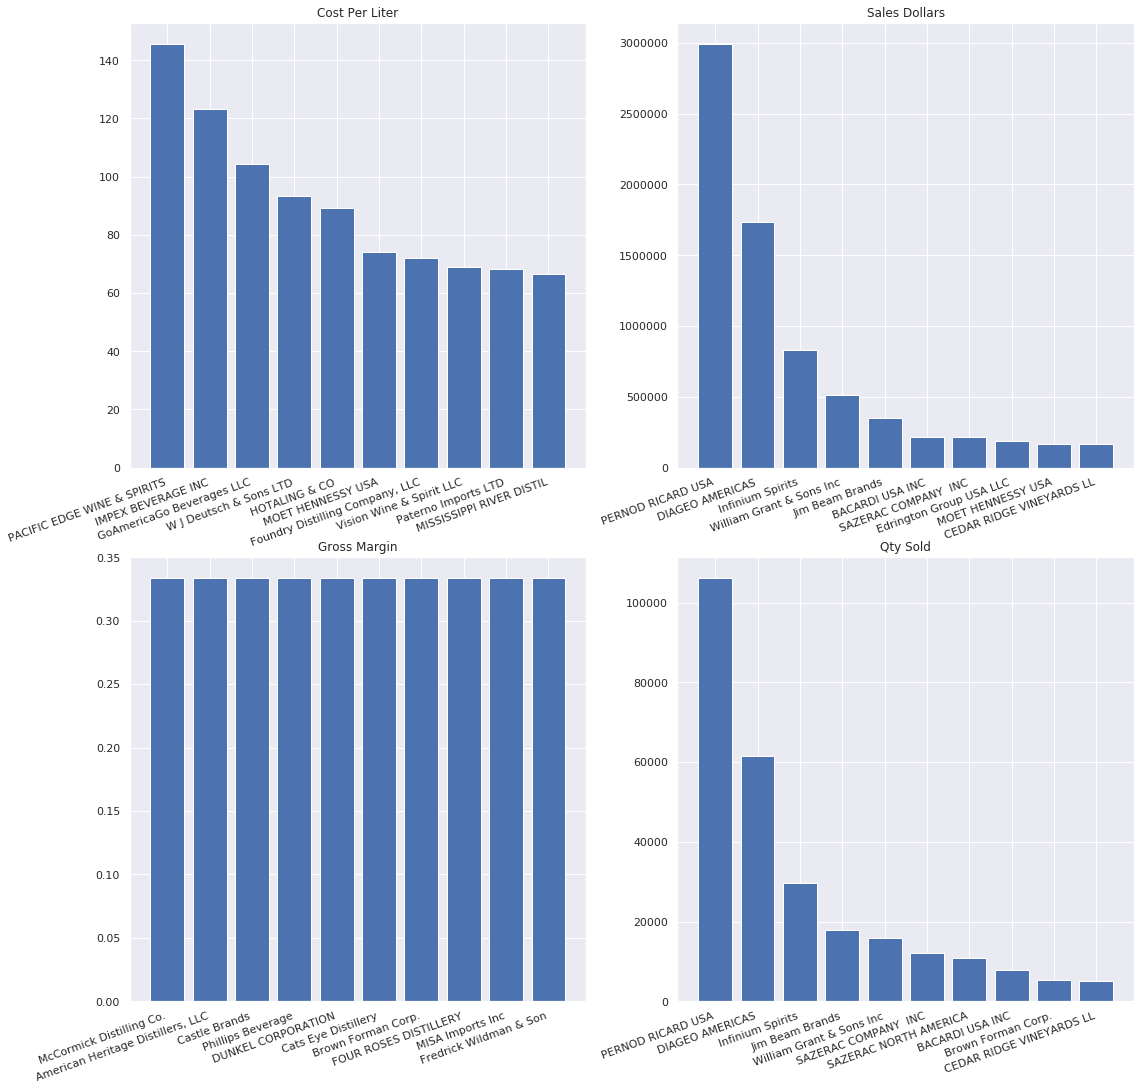

In [108]:
salesbyvendor = salesbyvendor.reset_index()

fig, axs = plt.subplots(2, 2, figsize=(18, 18))
sales_rate = salesbyvendor.sort_values(by='sale_dollars', ascending = False)
names = salesbyvendor.sort_values(by='cost_per_liter', ascending=False)['vendor_name'].head(10)
values = salesbyvendor.sort_values(by='cost_per_liter', ascending=False)['cost_per_liter'].head(10)
names2 = salesbyvendor.sort_values(by='sale_dollars', ascending=False)['vendor_name'].head(10)
values2 = salesbyvendor.sort_values(by='sale_dollars', ascending=False)['sale_dollars'].head(10)
names3 = salesbyvendor.sort_values(by='grossmargin',  ascending=False)['vendor_name'].head(10)
values3 = salesbyvendor.sort_values(by='grossmargin',  ascending=False)['grossmargin'].head(10)
names4 = salesbyvendor.sort_values(by='bottles_sold',  ascending=False)['vendor_name'].head(10)
values4 =salesbyvendor.sort_values(by='bottles_sold',  ascending=False)['bottles_sold'].head(10)
axs[0, 0].bar(names, values)
axs[0, 0].set_title('Cost Per Liter')
axs[0, 0].set_xticklabels(names, rotation=20, horizontalalignment='right')
axs[0, 1].bar(names2, values2)
axs[0, 1].set_title('Sales Dollars')
axs[0, 1].set_xticklabels(names2, rotation=20, horizontalalignment='right')
axs[1, 0].bar(names3, values3)
axs[1, 0].set_title('Gross Margin')
axs[1, 0].set_xticklabels(names3, rotation=20, horizontalalignment='right')
axs[1, 1].bar(names4, values4)
axs[1, 1].set_title('Qty Sold')
axs[1, 1].set_xticklabels(names4, rotation=20, horizontalalignment='right')

## New Features

Some of the new features that we would like to join in on this data would be census data.  There might be good information correlated between education, population, income groups, age groups, employment that could help classifying which retailers are more likely to sell greater volumes of whiskey.  Because there is so many different types of liquor (over 130 category names), we created a new feature, liquor_category that generalizes the liquor.  This way we can look at whiskey in a general sense against the other liquors.  Also, a new feature that could be created from existing data would be the day of the week from the sale date.  Would use the day of the week to look at sales from a weekday perspective (Monday, Tues...Sat, Sun) perspective.  This way we can aggregate the sales by day of week to help on logistics and prevent stock outs.  Below is the list of new features called out: 
* Day of the week  
* Education  
* Median population  
* Income groups  
* Age groups  
* Employment  
* Grouping of Liquor Brands  

We also created a series of columns which were aggregates of other columns.  These new features were added to provide more insight into the sales data to give better view of the profatability, and the market size of whiskey so we can better analyze and predict within the dataset

* Cost Per Liter
  * cost_per_liter = sale_dollars / volume_sold_liters
  * This helps normalize the costing structure of each of the liquor and have a standard view on pricing.  Since the sale_dollars is based on the number of bottles sold * retail price, we weren't able to compare the cost of liquor effectively
* Total Cost
  * totalcost = state_bottle_cost * bottles_sold
  * Provides total cost of the whiskey and will be used in determining our operating margin
* Revenue 
  * revenue = state_bottle_cost * bottles_sold
  * Need to see how much revenue is being generated.  Basic metric used in running any business
* Gross Margin
  * grossmargin = (revenue - totalcost)/revenue
  * Need to see how profitable we are doing in whiskey sales
* Log Transform of Sales
  * The sale_dollars is heavily right skewed, so performing a log transformation on the data helps normalize the data.
* Log Transform of Volume Sold
  * The volume_sold_liters is heavily right skewed, performed a log transform on this data as well to normalize the data.
* Log Transform of Bottles sold
  * The bottles_sold feature with a log transform applied so that it normalizes the distribution
* Log Transform of Cost Per Liter
  * The Cost_per_liter feature with a log transform applied to normalize the distribution




## Exceptional Work 
Work that we would like to be evaluated as exceptional work would be what we did around the areas of:
 * Tableau Location Analysis
 * Feature Reduction using PCA and LDA as well as dropping highly correlated variables
 * Time series analysis across the entire 2012 to 2019 dataset via big query
 * One hot encoding done on the data 



### Tableau Location Analysis
We built a tableau dashboard out of the 2019 iowa dataset with interative maps of where the most volume of alcohol was sold as well as the a time series analysis of sales and volume by date over 2019. The map features a caption with the analysis of the visuals.

https://public.tableau.com/profile/daniel.clark1522#!/vizhome/WhiskeySaleStory/Story1?publish=yes

In [0]:
### Remove highly correlated features

In [0]:
df_corr = df.copy()

In [111]:
df_corr.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1.0921e+06,IMPORTED DISTILLED SPIRIT SPECIALTY,293,JINRO AMERICA INC,989215,JINRO CHAMISUL GRAPEFRUIT SOJU,20,375,3.85,5.78,20.0,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,0.333910
1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,1.0913e+06,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,OLE SMOKY APPLE PIE MOONSHINE 70PRF MINI,8,50,8.75,13.13,1.0,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,0.333587
2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0421e+06,IMPORTED DRY GINS,35,BACARDI USA INC,28233,BOMBAY SAPPHIRE GIN,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,0.333333
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438
4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1.9012e+06,SPECIAL ORDER ITEMS,285,Charles Jacquin Et Cie,902291,SOOH BARTENDERS BANANAS OVER YOU,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,0.333572


In [112]:

# Create correlation matrix
corr_matrix = df_corr.corr().abs()
corr_matrix

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
pack,1.000000,0.583376,0.396909,0.396613,0.197974,0.044329,0.045399,0.045420,0.149088,0.111411,0.031250,0.659579,0.285858,0.097873,0.029256
bottle_volume_ml,0.583376,1.000000,0.257163,0.256866,0.050324,0.070925,0.116995,0.117054,0.244269,0.282219,0.487253,0.406372,0.026219,0.490400,0.015925
state_bottle_cost,0.396909,0.257163,1.000000,0.998987,0.094551,0.093317,0.008615,0.008617,0.274887,0.298577,0.491705,0.824341,0.269951,0.085615,0.021261
state_bottle_retail,0.396613,0.256866,0.998987,1.000000,0.094477,0.093215,0.008620,0.008622,0.274663,0.298243,0.491232,0.823560,0.269661,0.085501,0.005495
bottles_sold,0.197974,0.050324,0.094551,0.094477,1.000000,0.806402,0.852826,0.852826,0.419954,0.048674,0.083678,0.172085,0.526076,0.380934,0.004968
sale_dollars,0.044329,0.070925,0.093317,0.093215,0.806402,1.000000,0.859482,0.859482,0.474039,0.013155,0.017666,0.109463,0.394611,0.361270,0.002498
volume_sold_liters,0.045399,0.116995,0.008615,0.008620,0.852826,0.859482,1.000000,1.000000,0.371699,0.047608,0.098178,0.007940,0.360519,0.351944,0.000039
volume_sold_gallons,0.045420,0.117054,0.008617,0.008622,0.852826,0.859482,1.000000,1.000000,0.371718,0.047615,0.098212,0.007950,0.360531,0.351980,0.000039
sale_dollars_trans,0.149088,0.244269,0.274887,0.274663,0.419954,0.474039,0.371699,0.371718,1.000000,0.042377,0.008465,0.308425,0.781589,0.790142,0.006441
cost_per_liter,0.111411,0.282219,0.298577,0.298243,0.048674,0.013155,0.047608,0.047615,0.042377,1.000000,0.691285,0.220768,0.186546,0.456984,0.006487


In [0]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# courtesy of https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

In [114]:
to_drop

['state_bottle_retail', 'volume_sold_gallons']

Looking at our correlation matrix, we can deem that per our criteria of removing features that have a greater than 95% correlation. As the predictability of one feature will detirmine another, which will cause us to want to do a dimensionality reduction. 
In our case, we are going to remove state_bottle_retail as it correlates highly with state_bottle_cost, as well as volume_sold_gallons as it correlates perfectly with volume_sold_liters.

In [0]:
# Drop features 
df_corr = df_corr.drop(df_corr[to_drop], axis=1)

### Feature Reduction using PCA and LDA
PCA
To run a PCA analysis, we will want to first remove some of the highly correlated variables which may throw off our analysis. This will mean we should run a correlation plot and set our correlation threshold to 0.95, which we will remove variables if we exceed. 

First lets take a look at our seaborn plot that we will use to run principal component analysis. To get started, we will want to create dummies for each of our categories of alcohol, so that we have a single binary under Whiskey as the sale was a whiskey drink (1) or it was not (0)

In [0]:
df_corr2 = pd.get_dummies(df['liquor_category'], drop_first=False)

df_corr = pd.concat([df_corr, df_corr2], axis = 1, sort=False)



In [117]:
# now let's use PCA, and LDA to find the two "best" dimensions of this data
# these are linear transforms to help project the features into something more understandable

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#drop the response variable from x
# one hot encoding to category
features = ['pack', 'bottle_volume_ml', 'state_bottle_cost', 'bottles_sold', 'sale_dollars_trans', 'volume_sold_liters']

X = df_corr.loc[:, features].values
# run this second line below which compiles all the features that i want to use to predict category, or the column we want to predict
#X = X.drop (category, inplace = True)
y = df_corr.loc[:, ['WHISKY']].values
#target_names = df_corr.store_parent_names

pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X) # fit data and then transform it

lda = LDA(n_components=2)
X_lda = lda.fit(X, y).transform(X) # fit data and then transform it

# print the components

print ('pca:', pca.components_)
print ('lda:', lda.scalings_.T)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(6, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


pca: [[-8.76772443e-03  9.99901289e-01  3.74780890e-03 -3.38111153e-03
   4.65116586e-04  9.73881295e-03]
 [ 1.24510277e-02 -5.35907991e-03 -8.40892784e-03  6.24229067e-01
   7.24862636e-03  7.81044859e-01]]
lda: [[-0.00589082 -0.00095126  0.13870644 -0.00166674  0.04170408  0.00042601]]


Now what we did here was isolate our categorical variable "Whiskey" and fit a pca and LDA model using the continuous variables remaining in the set. Using this, our model will be able to advise on how much we can explain variance using the different principal components. 
Scaling it in this way allows our model to utilize and compare all variables on the same plane. 

In [118]:
principalDf = pd.DataFrame(data = X_pca
             , columns = ['principal component 1', 'principal component 2'])

principalDf.describe()

,principal component 1,principal component 2
count,4.000000e+05,4.000000e+05
mean,2.130926e-11,1.470755e-12
std,5.578664e+02,5.748631e+01
min,-9.352922e+02,-3.959859e+01
25%,-2.101569e+02,-1.185425e+01
50%,-2.100968e+02,-9.353322e+00
75%,7.898191e+02,-1.319139e+00
max,5.040052e+03,7.504936e+03


creating a dataframe of our principal components, we can see that there is quite a range in the values we have, from the negatives to the positives, with also a strong standard deviation. 
The mean principal component is nearly off the scale due to the effect of outliers. 

In [119]:
finalDf = pd.concat([principalDf, df_corr[['WHISKY']]], axis = 1)

finalDf.head()

,principal component 1,principal component 2,WHISKY
0,-585.208120,4.613021,0
1,-910.061786,-11.530798,0
2,39.880582,-8.851344,0
3,-209.967866,12.994968,1
4,789.958060,2.577026,0


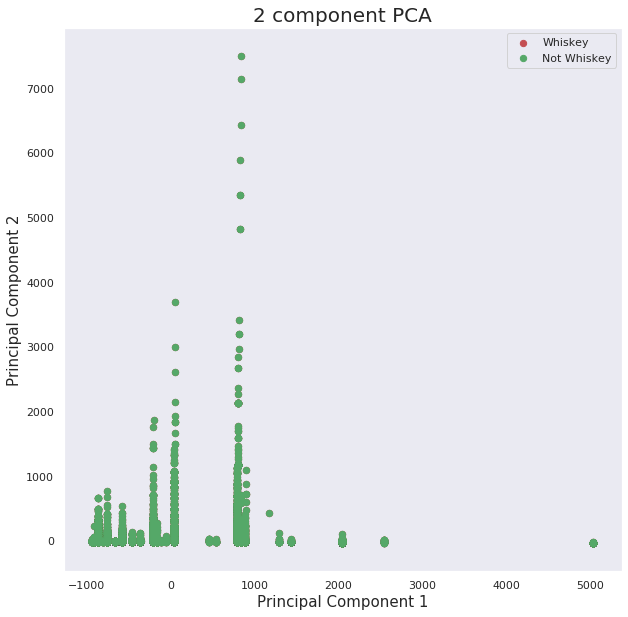

In [120]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Whiskey', 'Not Whiskey']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['WHISKY'] == 0
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 40)
ax.legend(targets)
ax.grid()

Looking at the plot we graphed, we can see the effect of outliers and the fact that non/whiskies have quite a presence in our chart. 
Our explained variance ratio below shows that we can explain 97% of the variance with one principal component, and less than 3% with the second principal component.

In [121]:
pca.explained_variance_ratio_

array([0.98843761, 0.01049585])

In [122]:
#lets transform our outliers to make them easier to read. 

finalDf2 = finalDf

finalDf2['principal component 1 trans'] = np.log(finalDf['principal component 1'])
finalDf2['principal component 2 trans'] = np.log(finalDf['principal component 2'])

finalDf2.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,principal component 1,principal component 2,WHISKY,principal component 1 trans,principal component 2 trans
0,-585.208120,4.613021,0,NaN,1.528883
1,-910.061786,-11.530798,0,NaN,NaN
2,39.880582,-8.851344,0,3.68589,NaN
3,-209.967866,12.994968,1,NaN,2.564562
4,789.958060,2.577026,0,6.67198,0.946636


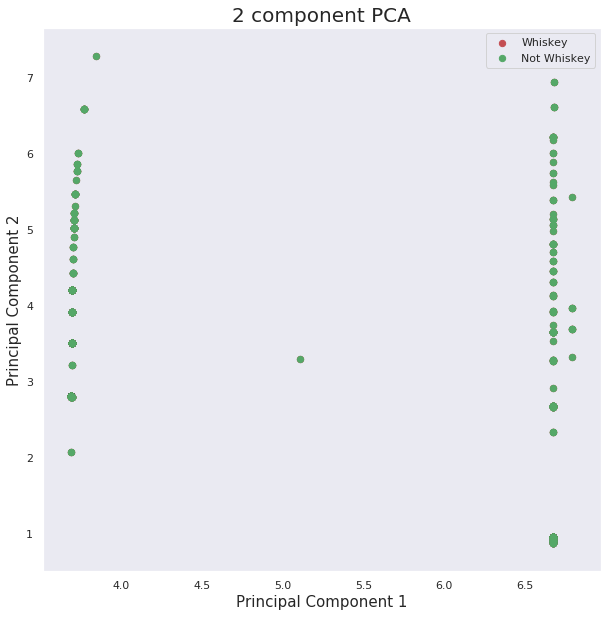

In [123]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Whiskey', 'Not Whiskey']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf2['WHISKY'] == 1
    ax.scatter(finalDf2.loc[indicesToKeep, 'principal component 1 trans']
               , finalDf2.loc[indicesToKeep, 'principal component 2 trans']
               , c = color
               , s = 40)
ax.legend(targets)
ax.grid()

To make our chart easier to read, i decided to take a transform of our principal components to normalize their distribution. As you can see, their values separate a lot more in our dataset. However, the non whiskey values play a small presence.

### Time series analysis across the entire 2012 to 2019 dataset via big query

Registered for credentials with Google Cloud and Big Query to be able to query our database and data frame from 17 million datapoints for analysis on our project. 

In our Visualize Attributes section, we went into a deep dive on the analysis of whiskey as well as Hy-Vee to understand their effect on the dataset.

Because the dataset is so large, 17.7 million rows and over 4GB in size, we couldn't pull the entire dataset from BigQuery into Pandas.  

So, initial analysis of the entire dataset was done by querying BigQuery

First needed to connect to BigQuery, then do a some EDA against the data set by querying BigQuery and visualize those results to determine a good subset of the data.

In [124]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
project_id = 'smu-7331-ml'

plt.rc('axes', axisbelow=True)

# Imports the Google Cloud client library
#from google.cloud import bigquery
# Instantiates a client for BigQuery Service
#bqclient = bigquery.Client()

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

from google.cloud import bigquery
bqclient = bigquery.Client(project=project_id)


Authenticated


#### Functions

##### Execute Query

In [0]:
def execute_query(QUERY):
    # Run the query and get data from BQ
    query_job = bqclient.query(QUERY)
    return query_job.to_dataframe()

#### Exploratory Data Analysis

##### Total data size and column types

In [126]:
QUERY="""
    SELECT
        count(*) as TotalRows
    FROM `bigquery-public-data.iowa_liquor_sales.sales`
"""
df=execute_query(QUERY)
df

,TotalRows
0,17735173


##### Get Columns and Data Types for Columns

In [127]:
QUERY="""
    SELECT
        *
    FROM `bigquery-public-data.iowa_liquor_sales.sales`
    LIMIT 10
"""
df=execute_query(QUERY)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 24 columns):
invoice_and_item_number    10 non-null object
date                       10 non-null object
store_number               10 non-null object
store_name                 10 non-null object
address                    10 non-null object
city                       10 non-null object
zip_code                   10 non-null object
store_location             10 non-null object
county_number              10 non-null object
county                     10 non-null object
category                   10 non-null object
category_name              10 non-null object
vendor_number              10 non-null object
vendor_name                10 non-null object
item_number                10 non-null object
item_description           10 non-null object
pack                       10 non-null int64
bottle_volume_ml           10 non-null int64
state_bottle_cost          10 non-null float64
state_bottle_retail      

In [128]:
pd.set_option('display.max_columns', None)
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-08269700125,2017-10-26,5102,Wilkie Liquors,724 1st St SE,Mount Vernon,52314,POINT (-91.410401 41.918328),57,LINN,1062300,Aged Dark Rum,460,Shaw-Ross International,44266,British Navy Pusser's Rum,6,750,12.02,18.03,18,324.54,13.5,3.57
1,S08774900041,2012-11-06,3952,Lot-A-Spirits,3780 STATE ST,BETTENDORF,52722,POINT (-90.48065 41.529655),82,Scott,1081317,GRAPE SCHNAPPS,65,Jim Beam Brands,82637,Dekuyper Grape Pucker,12,1000,7.35,11.02,84,925.68,84.0,22.19
2,S13126400077,2013-07-02,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,COUNCIL BLUFFS,51501,POINT (-95.8792 41.238092),78,Pottawattamie,1081312,BUTTERSCOTCH SCHNAPPS,65,Jim Beam Brands,82787,Dekuyper Buttershots,12,1000,7.62,11.43,8,91.44,8.0,2.11
3,S32801600011,2016-06-13,4024,Wal-Mart 1546 / Iowa Falls,840 S Oak,Iowa Falls,50126,POINT (-93.262446 42.503407),42,Hardin,1701100,DECANTERS & SPECIALTY PACKAGES,260,Diageo Americas,183,Smirnoff 1.75L Glass w/2-50mls,6,1850,14.75,22.13,6,132.78,11.1,2.93
4,S32909400205,2016-06-16,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,Polk,1081330,PEACH SCHNAPPS,65,Jim Beam Brands,82847,Dekuyper Peachtree,12,1000,7.87,11.81,84,992.04,84.0,22.19


##### Look at distribution of data for each Year-Month

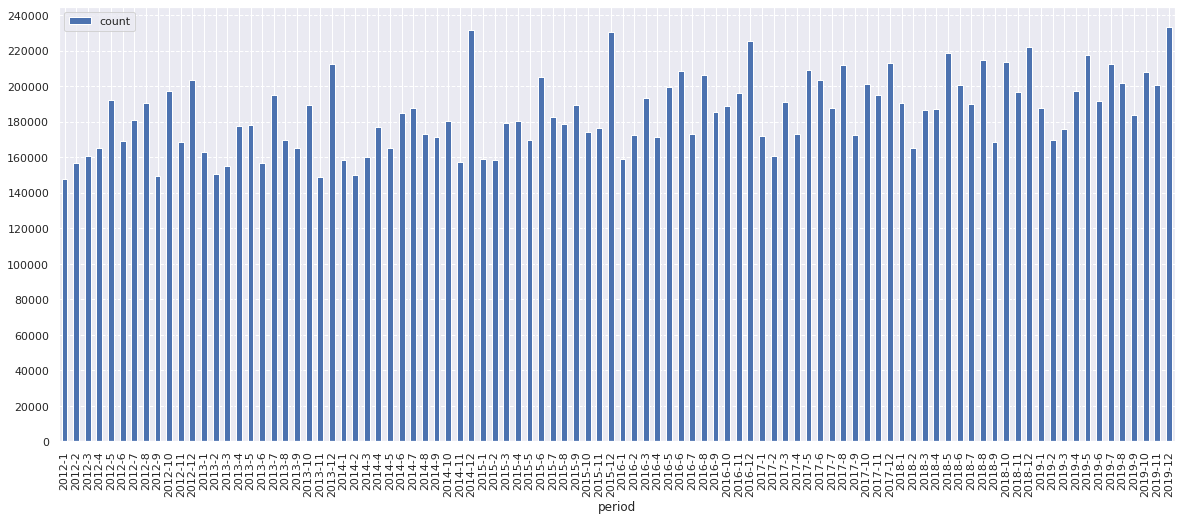

In [129]:
# How many rows of data for each month for each year 
QUERY="""
SELECT
    extract(YEAR from date) as year,
    extract(MONTH from date) as month,
    count(*) as count
FROM `bigquery-public-data.iowa_liquor_sales.sales`
group by year, month
order by year, month
"""
df = execute_query(QUERY)

# Plot the results
df['period'] = df['year'].map(str) +'-' +df['month'].map(str)
#df.groupby(['year', 'month'])['count'].sum().plot(kind='bar', figsize=(20, 8))
plot=df.plot(kind='bar', x='period', y='count', figsize=(20,8))
#xtick = pd.date_range( start=ts.index.min( ), end=ts.index.max( ), freq='W' )
#plot.set_xticks( xtick, minor=True )
#plot.grid('off', which='minor', axis='y' )
plot.grid('on', axis='y', linestyle='dashed')
plt.yticks(np.arange(0, max(df['count']+10000), 20000))
plt.show()

##### Determine the different liquor categories

In [130]:
# How many rows of data for each month for each year 
QUERY="""
SELECT
    category_name,
    count(*) as count
FROM `bigquery-public-data.iowa_liquor_sales.sales`
group by category_name
order by category_name
"""
df = execute_query(QUERY)
df

,category_name,count
0,None,24358
1,100 PROOF VODKA,99124
2,100% Agave Tequila,205653
3,AMARETTO - IMPORTED,102
4,AMERICAN ALCOHOL,24351
...,...,...
125,WHISKEY LIQUEUR,334572
126,WHITE CREME DE CACAO,7213
127,WHITE CREME DE MENTHE,2459
128,Whiskey Liqueur,367183


##### Group vodka, rum, whiskey, tequila as separate categories, and everything else as other

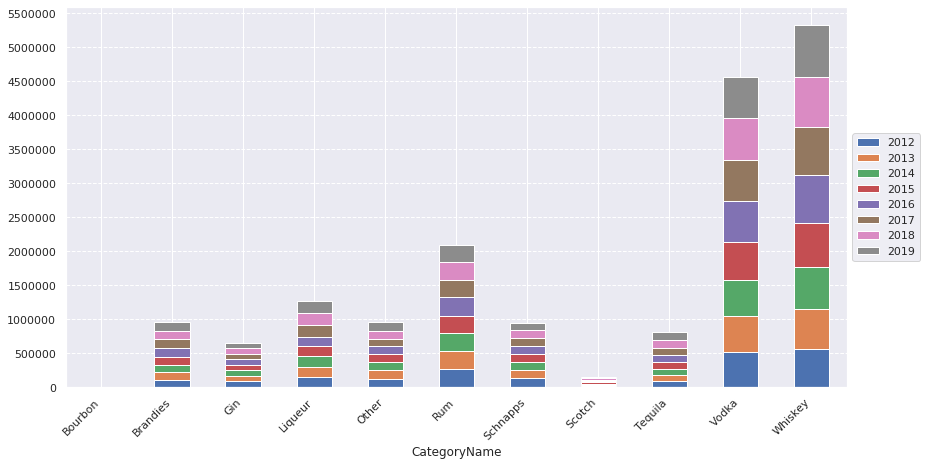

In [131]:
QUERY="""
SELECT
CASE
  WHEN lower(category_name) like '%rum%' then 'Rum'
  WHEN lower(category_name) like '%whisk%' then 'Whiskey'
  WHEN lower(category_name) like '%vodka%' then 'Vodka'
  WHEN lower(category_name) like '%tequila%' then 'Tequila'
  WHEN lower(category_name) like '%schnapps%' then 'Schnapps'
  WHEN lower(category_name) like '%gin%' then 'Gin'
  WHEN lower(category_name) like '%bourbon%' then 'Bourbon'
  WHEN lower(category_name) like '%brandies%' then 'Brandies'
  WHEN lower(category_name) like '%liqueur%' then 'Liqueur'
  WHEN lower(category_name) like '%scotch%' then 'Scotch'
  ELSE 'Other'
END
as CategoryName,
extract(Year from date) as Year,
extract(month from date) as Month,
count(*) as Count
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`
group by year, month, categoryname
order by year, month, CategoryName
"""
df = execute_query(QUERY)
catYear=df.groupby(['CategoryName', 'Year'])['Count'].sum().unstack().plot(kind='bar', stacked=True, figsize=(14,7))
catYear.grid('on', axis='y', linestyle='dashed')
plt.yticks(np.arange(0, 6000000, 500000))
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

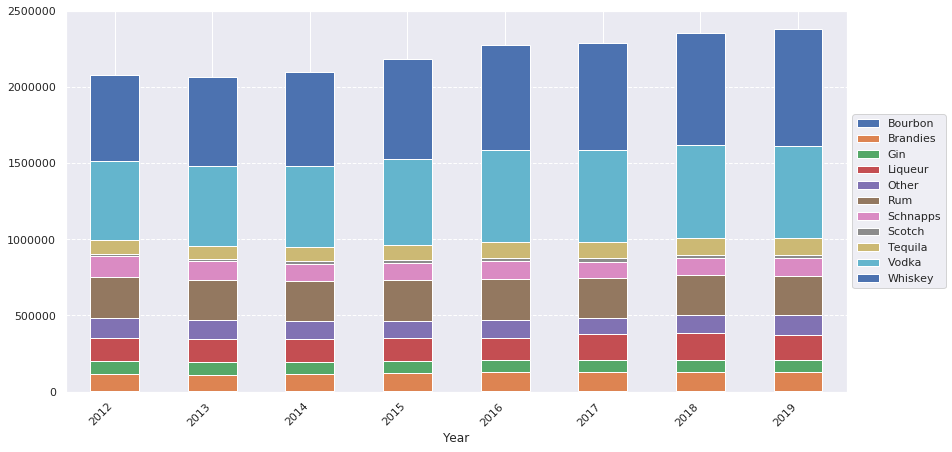

In [132]:
yearCat=df.groupby(['Year', 'CategoryName'])['Count'].sum().unstack().plot(kind='bar', stacked=True, figsize=(14,7))
yearCat.grid('on', axis='y', linestyle='dashed')
plt.yticks(np.arange(0, 3000000, 500000))
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

#### Subset the data

Based on the results above, we decided to go with 400,000 random rows from 2019.

Our challenge was with github only allowing a file smaller than 100mb.  So we found that 400k rows came in at 95mb.

Because there wasn't a particular sort column, we simply extracted 400k rows from BigQuery by executing the following query:


```
SELECT
  *
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE
date between "2019-01-01" and "2019-12-31" limit 400000;
```

Once executed, we were able to save the results (400,000 rows) to a csv, and that is what we are using for our data set


### One Hot Encoding
To be able to put our dataset into a manner that allows us to analyze further, we ran a one hot encoding procedure that isolated the categorical variables and one-hotted the ones that exceeded 30 uniques. This was done in our data cleaning stage earlier in this doc.